
# Introducing Mechanical Power as a Unifying Metric

In recent years, the concept of **Mechanical Power (MP)** has emerged as a comprehensive parameter that integrates all the ventilator settings contributing to energy delivery to the respiratory system. In the context of mechanical ventilation, MP is the total energy transferred from the ventilator to the lungs and chest wall in one minute, typically expressed in Joules per minute (J/min). This metric provides a holistic view of the mechanical load, accounting for the combined effects of tidal volume, respiratory rate, pressure, and flow. The total mechanical power delivered per minute can be seen as the sum of elastic, resistive, and PEEP-related components.

---
> **Repository at** [Omics_AiSeeYou](https://github.com/Molderon/Omics_AiSeeYou) <br>
> Previous phase: [Dataset assembly](https://github.com/Molderon/Omics_AiSeeYou/blob/main/RespiratoryCare/Mechanical%20Power/MechanicalPower_Assembly.ipynb)<br>
> Next : [Convilution & LSTM](https://github.com/Molderon/Omics_AiSeeYou/blob/main/RespiratoryCare/Mechanical%20Power/Mechanical%20Power.ipynb) | Deep Learning
---
## Research contents  
The dataset undergoes the following analytical examinations:  

1. **Dimensionality Reduction & Visualization**  
   - **PCA Scans**: Identify dominant linear correlations and reduce feature space.  
   - **UMAP**: Balance local/global structure preservation for improved clustering.  

2. **Statistical & Temporal Analysis**  
   - **Scatter/Heat Maps**: Visualize pairwise relationships and correlation matrices.  
   - **Time Series Analysis (TSA)**: Detect trends, seasonality, or anomalies in temporal data.  

3. **Destribution and Correlations per feature**
   - **Visualizations**: (Histogram, Box Plot, Violin plot)

4. **Parameter Magnitude**: Conclusion
---


In [1]:
# -<Python STD>-
from typing import Dict, Any, Optional, Union, Callable
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import time, gc, os


# -<Data Containment>-
import pandas as pd
import numpy as np


# -<Data Formatting>-
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from functools import reduce # For merging DataFrames


# -<Information Analysis>-
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import shap


# -<Time series analysis>-
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox


# -<Visualizing correlations>-
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px


# -<Machine Learning>-
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import is_regressor
import xgboost as xgb


# -<Do not be annoying>
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')
warnings.filterwarnings("ignore", category=FutureWarning, module='statsmodels')

In [2]:
def GiveMeData(ScaleMe:bool, TimeStepPlease:bool) -> pd.DataFrame:
    dataset= pd.read_csv("Dataset.csv", index_col=False)
    dataset.drop(dataset.columns[[0]], inplace=True, axis=1)

    imputer = SimpleImputer(strategy='mean')

    cols = dataset.columns
    data = imputer.fit_transform(dataset)
    dataset = pd.DataFrame(data, columns=cols)

    if ScaleMe == True:
        scaler = StandardScaler()
        features = dataset.columns
        scaled_data = scaler.fit_transform(dataset.to_numpy())
        dataset = pd.DataFrame(scaled_data, columns=features)

    if TimeStepPlease == False:
        dataset.drop(['Time'], axis =1, inplace=True)

    Y_targets: pd.DataFrame = dataset[['MP_LM', 'MP_SB', 'MP_vdM', 'MP_CB']]
    dataset.drop(['Case ID','MP_LM', 'MP_SB', 'MP_vdM', 'MP_CB', 't_slope'], axis =1, inplace=True)
    dataset.head()
    return dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/Colab_Notebooks/MechanicalPower/")

In [3]:
dataset = GiveMeData(ScaleMe=True, TimeStepPlease=True)

# Time Series Analysis and Dataset Preparation

---

This segment is dedicated to a comprehensive **Time Series Analysis (TSA)** of the extacted data. <br>
The primary goal is to decompose the time series, identify and confirm if the raw extracted data has a presence of **noise**, and prepare a clean, **non-normalized** dataset for advanced modeling.

The workflow is as follows:
1.  **Decomposition & Noise Confirmation:** Perform a seasonal decomposition to separate the time series into trend, seasonality, and residual components. <br> The residuals will then be rigorously analyzed using statistical tests (e.g., **ACF plot, ADF test, and Ljung-Box test**) to confirm they represent pure, random noise.

2.  **Data Cleaning:** Inconsistent or anomalous records will be identified and removed.


In [ ]:
class TemporalDecomposition:

    def __init__(self, dataset: pd.DataFrame, bio_feature: str, datetime_col: str = None, freq: str = None):

        if not isinstance(dataset, pd.DataFrame):
            raise TypeError("Input 'dataset' must be a pandas DataFrame.")
        if bio_feature not in dataset.columns:
            raise ValueError(f"'{bio_feature}' not found in DataFrame columns.")

        self.dataset = dataset.copy()
        self.bio_feature = bio_feature
        self.datetime_col = datetime_col

        # Ensure index is datetime and sorted
        if self.datetime_col:
            if self.datetime_col not in self.dataset.columns:
                raise ValueError(f"Datetime column '{datetime_col}' not found in DataFrame.")
            self.dataset[self.datetime_col] = pd.to_datetime(self.dataset[self.datetime_col])
            self.dataset = self.dataset.set_index(self.datetime_col).sort_index()
        elif not isinstance(self.dataset.index, pd.DatetimeIndex):
            raise TypeError("DataFrame index must be of type DatetimeIndex if no 'datetime_col' is provided.")

        # Infer frequency if not provided
        if freq:
            self.freq = freq
            if self.dataset.index.freq is None or str(self.dataset.index.freq) != freq:
                # Ensure the index has the specified frequency
                try:
                    self.dataset = self.dataset.asfreq(self.freq)
                except Exception as e:
                    print(f"Warning: Could not set frequency '{self.freq}' to DataFrame index. Error: {e}")
                    print("Ensure your data points are regularly spaced or resample.")
        else:
            self.freq = pd.infer_freq(self.dataset.index)
            if not self.freq:
                raise ValueError(
                    "Could not infer frequency. Please provide 'freq' parameter "
                    "or ensure your datetime index has a consistent frequency."
                )
            print(f"Inferred frequency: {self.freq}")

        self.residuals = None
        self.decomposition_results = None # Renamed for clarity

        sb.set_style("darkgrid") # Set a default seaborn style



    def decompose_biosignal(self, period: int = None, model: str = 'additive', extrapolate_trend: int = 'freq') -> dict:

        if period is None:
            raise ValueError("The 'period' parameter is crucial, please provide it\n.")

        biosignal = self.dataset[self.bio_feature].dropna()

        if len(biosignal) < 2 * period:
            raise ValueError(
                f"Biosignal length ({len(biosignal)}) is too short for the specified period ({period}). "
                f"Needs at least 2 * period for decomposition. Consider a smaller period or more data."
            )

        try:
            decomposition = seasonal_decompose(
                biosignal,
                model=model,
                period=period,
                extrapolate_trend=extrapolate_trend
            )
            self.decomposition_results = decomposition
            self.residuals = decomposition.resid.dropna()

            print(f"Decomposition successful for '{self.bio_feature}' with period={period} and model='{model}'.")

            return {
                'trend': decomposition.trend,
                'seasonal': decomposition.seasonal,
                'resid': decomposition.resid,
                'observed': decomposition.observed # Include observed for completeness
            }
        except Exception as e:
            print(f"Error during decomposition: {e}")
            self.decomposition_results = None
            self.residuals = None
            return {}



    def plot_decomposition(self, figsize=(12, 10)):
        if self.decomposition_results is None:
            raise ValueError("Run decompose_biosignal() first to get decomposition results.")

        fig = self.decomposition_results.plot()
        fig.set_size_inches(figsize)
        fig.suptitle(
            f'{self.bio_feature} Decomposition (Period={self.decomposition_results.seasonal.index.freqstr or self.freq})',
            y=1.02,
            fontsize=16
        )
        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
        plt.show()



    def analyze_residuals(self, acf_lags: int = None, pacf_lags: int = None, lb_lags: list = None) -> dict:

        if self.residuals is None or self.residuals.empty:
            raise ValueError("Residuals are not available. Run decompose_biosignal() first and ensure it returns valid residuals.")

        results = {}
        residuals = self.residuals

        # Determine default lags based on series length
        max_lags = max(1, len(residuals) // 3) # A common heuristic
        acf_lags = acf_lags if acf_lags is not None else min(40, max_lags)
        pacf_lags = pacf_lags if pacf_lags is not None else min(40, max_lags)
        lb_lags = lb_lags if lb_lags is not None else [max(1, int(0.25 * acf_lags)), max(1, int(0.5 * acf_lags)), max(1, acf_lags)]
        lb_lags = sorted(list(set(l for l in lb_lags if l > 0 and l < len(residuals)))) # Ensure valid lags

        if not lb_lags:
            print("Warning: No valid lags for Ljung-Box test due to short residual series. Skipping Ljung-Box.")
            results['Ljung-Box'] = "Skipped due to insufficient data."

        # 1. Plot ACF and PACF
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        plot_acf(residuals, lags=acf_lags, ax=axes[0], alpha=0.05, title=f'ACF of Residuals ({self.bio_feature})')
        plot_pacf(residuals, lags=pacf_lags, ax=axes[1], alpha=0.05, title=f'PACF of Residuals ({self.bio_feature})')
        plt.tight_layout()
        plt.show()



        # 2. ADF Test
        print("\nPerforming Augmented Dickey-Fuller (ADF) Test on Residuals...")
        try:
            adf_result = adfuller(residuals)
            results['ADF'] = {
                'statistic': adf_result[0],
                'pvalue': adf_result[1],
                'n_lags': adf_result[2],
                'n_obs': adf_result[3],
                'critical_values': adf_result[4],
                'model': adf_result[5]
            }
        except Exception as e:
            print(f"Error performing ADF test: {e}")
            results['ADF'] = "Failed to run ADF test."


        # 3. Ljung-Box Test
        if 'Ljung-Box' not in results: # Only run if not skipped
            print("\nPerforming Ljung-Box Test on Residuals...")
            try:
                # acorr_ljungbox in statsmodels 0.12+ returns a DataFrame
                # Earlier versions might return different structures
                lb_test = acorr_ljungbox(residuals, lags=lb_lags, return_df=True)
                results['Ljung-Box'] = lb_test
            except Exception as e:
                print(f"Error performing Ljung-Box test: {e}")
                results['Ljung-Box'] = "Failed to run Ljung-Box test."

        return results



    def Report_PlainText(self, analysis_results: dict):

        print("\n" + "-"*70)
        print(f"DETAILED RESIDUAL ANALYSIS REPORT for {self.bio_feature}".center(70))
        print("="*70)

        # ADF Test Report
        if 'ADF' in analysis_results and isinstance(analysis_results['ADF'], dict):
            adf = analysis_results['ADF']
            print("\n--- Augmented Dickey-Fuller (ADF) Test Results ---")
            print(f"  ADF Statistic: {adf['statistic']:.4f}")
            print(f"  P-value: {adf['pvalue']:.4f}")
            print(f"  Number of Lags Used: {adf['n_lags']}")
            print(f"  Number of Observations Used: {adf['n_obs']}")
            print("  Critical Values:")
            for key, value in adf['critical_values'].items():
                print(f"    {key}: {value:.4f}")

            print("\n  Interpretation (ADF):")
            if adf['pvalue'] < 0.05:
                print("  ✅ The p-value is less than 0.05, indicating strong evidence to reject the null hypothesis.")
                print("     The residuals are likely stationary (do not have a unit root).")
            else:
                print("  ❌ The p-value is greater than 0.05, indicating insufficient evidence to reject the null hypothesis.")
                print("     The residuals might be non-stationary (may have a unit root). Further differencing might be needed.")
        else:
            print("\n--- ADF Test Results Not Available or Failed ---")

        # Ljung-Box Test Report
        if 'Ljung-Box' in analysis_results and isinstance(analysis_results['Ljung-Box'], pd.DataFrame):
            lb_test = analysis_results['Ljung-Box']
            print("\n--- Ljung-Box Test Results ---")
            print("  Tests for independence (white noise) at various lags:")
            print(lb_test.to_string()) # Use to_string for better formatting

            print("\n  Interpretation (Ljung-Box):")
            all_passed = True
            for lag, pvalue in lb_test['lb_pvalue'].items():
                if pvalue <= 0.05:
                    print(f"  ❌ At Lag {lag}: P-value ({pvalue:.4f}) <= 0.05. Significant autocorrelation detected.")
                    all_passed = False
                else:
                    print(f"  ✅ At Lag {lag}: P-value ({pvalue:.4f}) > 0.05. No significant autocorrelation detected.")

            if all_passed:
                print("\n  Overall: All Ljung-Box tests indicate no significant autocorrelation at the tested lags.")
                print("  This suggests the residuals are indistinguishable from white noise.")
            else:
                print("\n  Overall: Significant autocorrelation detected at one or more lags.")
                print("  This suggests the decomposition has not fully captured the underlying patterns.")
        elif 'Ljung-Box' in analysis_results:
            print(f"\n--- Ljung-Box Test Results: {analysis_results['Ljung-Box']} ---")
        else:
            print("\n--- Ljung-Box Test Results Not Available or Failed ---")

        # Overall Assessment
        print("\n--- Overall Residual Assessment ---")
        is_adf_stationary = (isinstance(analysis_results.get('ADF'), dict) and analysis_results['ADF']['pvalue'] < 0.05)
        is_lb_white_noise = (isinstance(analysis_results.get('Ljung-Box'), pd.DataFrame) and all(analysis_results['Ljung-Box']['lb_pvalue'] > 0.05))

        if is_adf_stationary and is_lb_white_noise:
            print("🎉🎉 Residuals are likely 'white' noise! This indicates a successful decomposition.")
            print("    The trend and seasonality components have effectively captured the systematic patterns.")
            print("    The remaining noise is random and unpredictable.")
        else:
            print("⚠️ RESIDUALS ARE NOT WHITE NOISE! Further investigation is required.")
            if not is_adf_stationary:
                print("    - ADF Test suggests non-stationarity. Consider differencing the *original* series or fitting a more complex model.")
            if not is_lb_white_noise:
                print("    - Ljung-Box Test indicates significant autocorrelation. This means there are still")
                print("      predictable patterns (e.g., higher-order seasonality or unmodeled autoregressive behavior)")
                print("      left in the residuals. Your decomposition might need refinement (e.g., different period, model, or a different TSA technique like ARIMA).")
        print("="*70)



    def full_analysis(self, period: int = None, model: str = 'additive',
                       extrapolate_trend: int = 'freq', acf_lags: int = None,
                       pacf_lags: int = None, lb_lags: list = None):

        print(f"\n{'-'*80}")
        print(f"Launching TSA for '{self.bio_feature}'".center(80))
        print(f"{'-'*80}\n")

        # 1. Perform decomposition
        print("\n--- Phase 1: Performing Seasonal Decomposition ---")
        decomposition_output = self.decompose_biosignal(
            period=period,
            model=model,
            extrapolate_trend=extrapolate_trend
        )
        if not decomposition_output:
            print("Decomposition failed. Aborting full analysis.")
            return {}

        self.plot_decomposition()

        # 2. Analyze residuals
        print("\n--- Phase 2: Analyzing Residuals ---")
        analysis_results = self.analyze_residuals(
            acf_lags=acf_lags,
            pacf_lags=pacf_lags,
            lb_lags=lb_lags
        )

        # 3. Report findings
        print("\n--- Phase 3: Generating Residual Analysis Report ---")
        self.Report_PlainText(analysis_results)

        print(f"\n{'-'*80}")
        print(f"Analysis Completed: '{self.bio_feature}'".center(80))
        print(f"{'-'*80}\n")

        return analysis_results

Ensure your data points are regularly spaced or resample.

--------------------------------------------------------------------------------
                       Launching TSA for 'SET_INSP_PRES'                        
--------------------------------------------------------------------------------


--- Phase 1: Performing Seasonal Decomposition ---
Decomposition successful for 'SET_INSP_PRES' with period=514 and model='additive'.


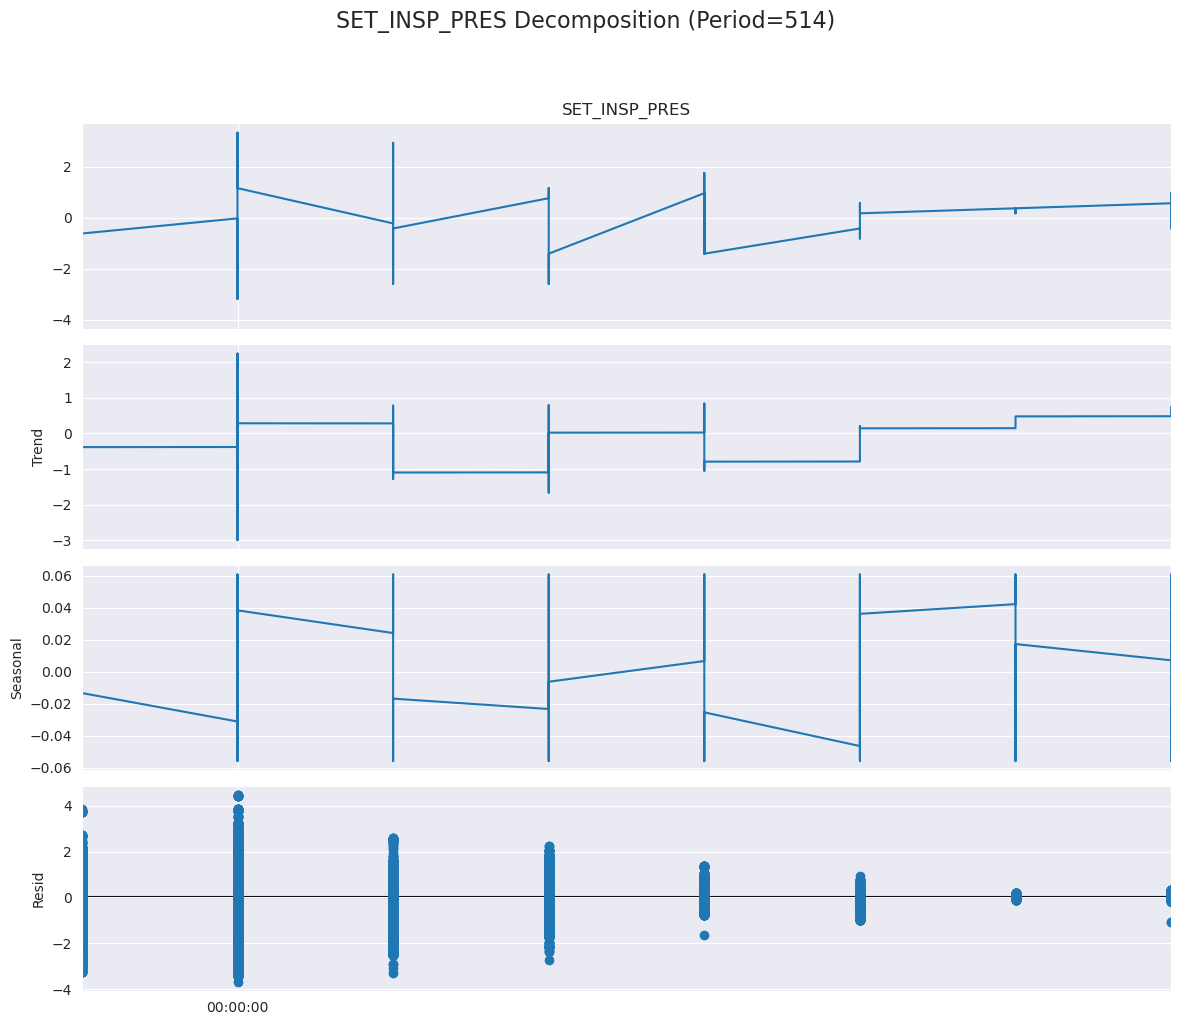


--- Phase 2: Analyzing Residuals ---


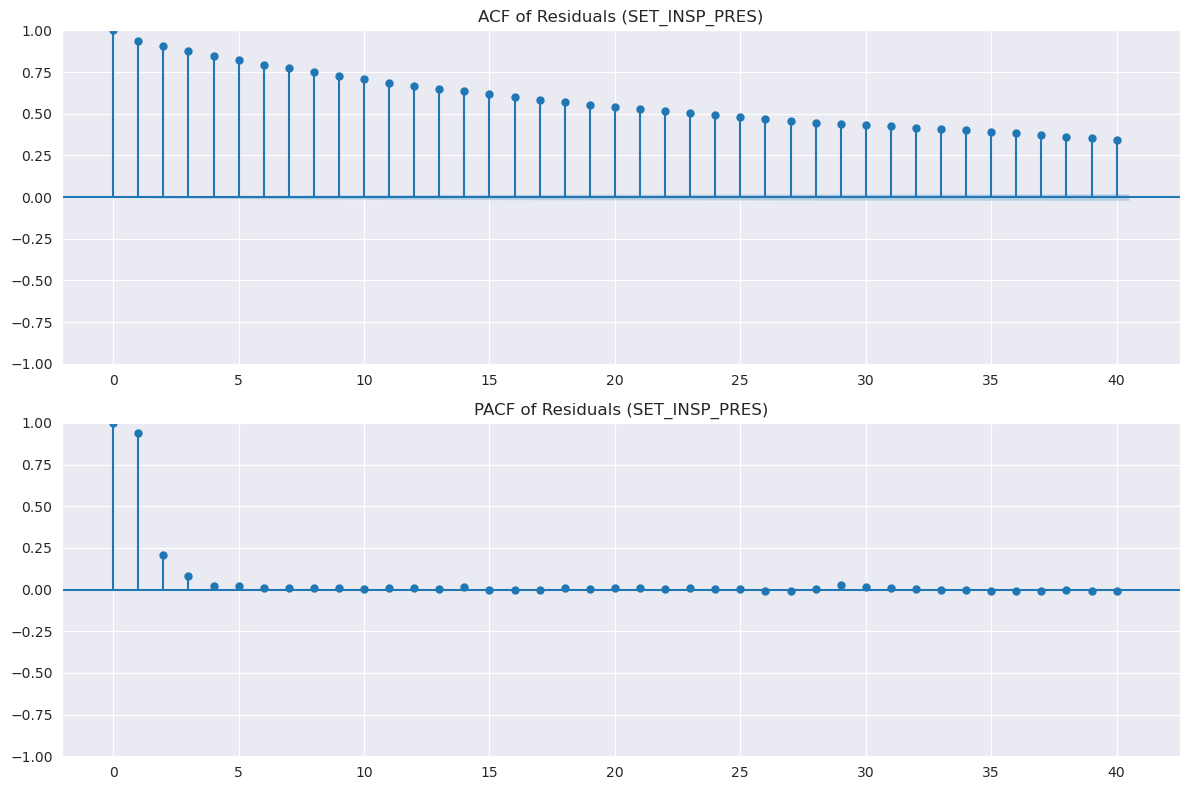


Performing Augmented Dickey-Fuller (ADF) Test on Residuals...

Performing Ljung-Box Test on Residuals...

--- Phase 3: Generating Residual Analysis Report ---

----------------------------------------------------------------------
         DETAILED RESIDUAL ANALYSIS REPORT for SET_INSP_PRES          

--- Augmented Dickey-Fuller (ADF) Test Results ---
  ADF Statistic: -44.7373
  P-value: 0.0000
  Number of Lags Used: 85
  Number of Observations Used: 251151
  Critical Values:
    1%: -3.4304
    5%: -2.8616
    10%: -2.5668

  Interpretation (ADF):
  ✅ The p-value is less than 0.05, indicating strong evidence to reject the null hypothesis.
     The residuals are likely stationary (do not have a unit root).

--- Ljung-Box Test Results ---
  Tests for independence (white noise) at various lags:
         lb_stat  lb_pvalue
10  1.673491e+06        0.0
20  2.615313e+06        0.0
40  3.563183e+06        0.0

  Interpretation (Ljung-Box):
  ❌ At Lag 10: P-value (0.0000) <= 0.05. Significant

In [ ]:
TSA = TemporalDecomposition(
        dataset=dataset,
        bio_feature='SET_INSP_PRES',
        datetime_col='Time',
        freq='514' # Explicitly set frequency
    )

# Perform analysis with hourly seasonality (3600s / 7s ≈ 514 periods)
results = TSA.full_analysis(period=514)

In [4]:
dataset.drop(['Time'], axis =1, inplace=True)

In [ ]:
def HeatMap(dataset: pd.DataFrame):
    data = sb.heatmap(dataset.corr(numeric_only=True))
    plt.show()

def DrawScatter(dataset: pd.DataFrame):
    scatter_matrix(dataset[dataset.columns], figsize=(24,18))

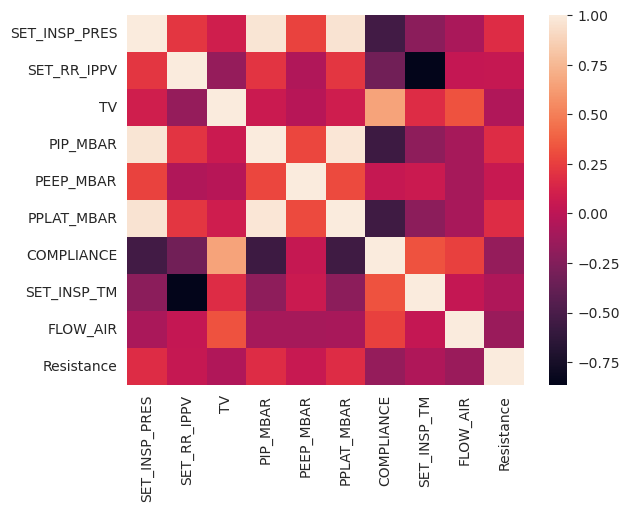

In [ ]:
HeatMap(dataset)

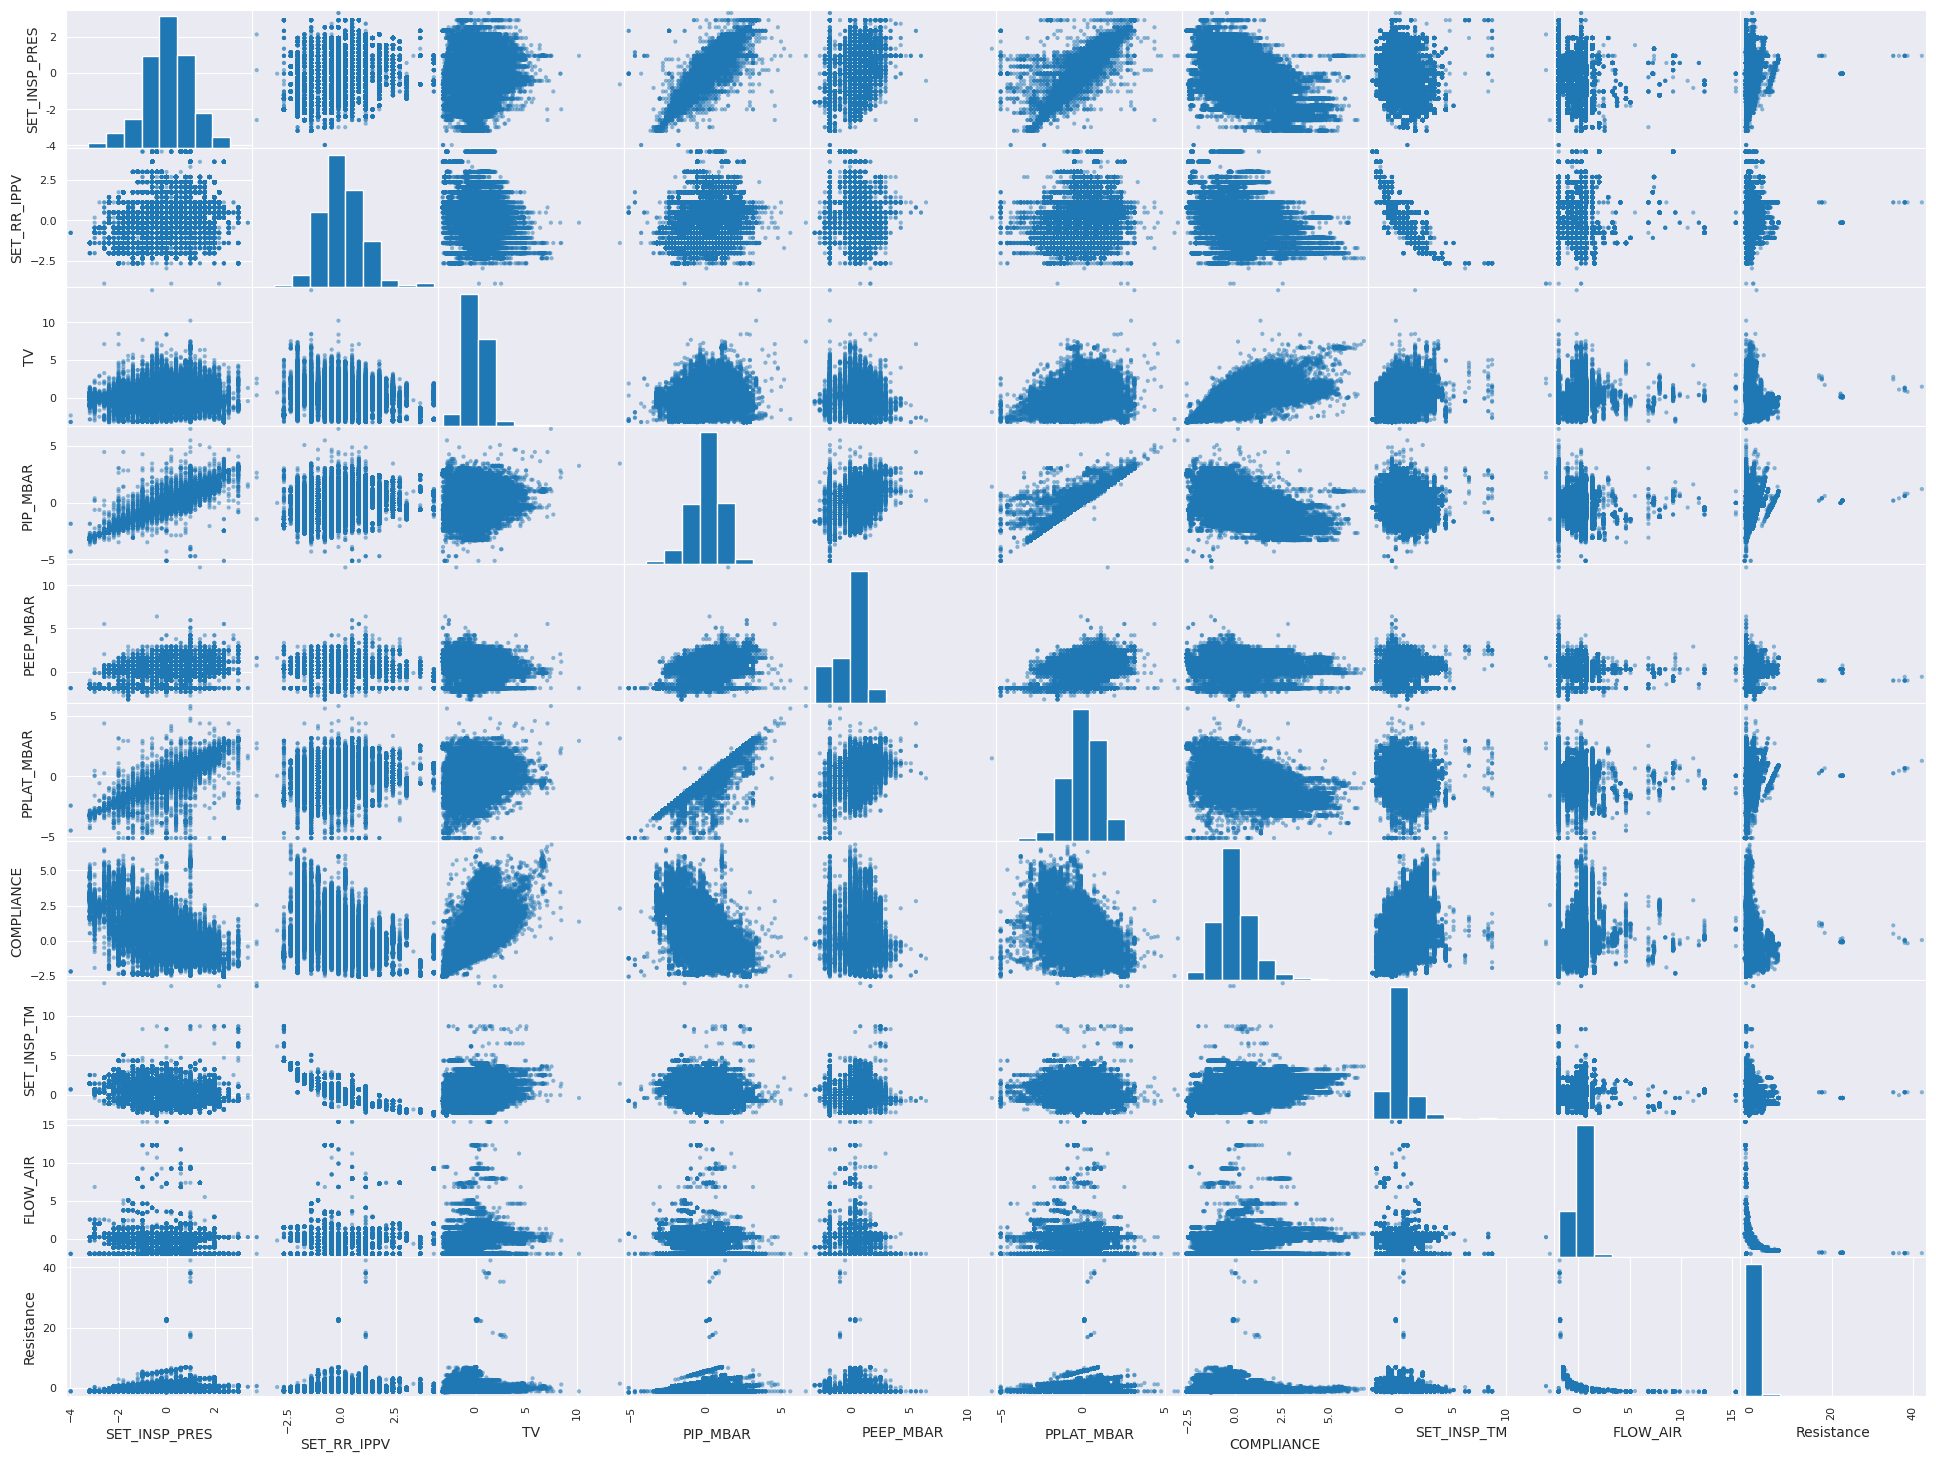

In [ ]:
DrawScatter(dataset)

In [ ]:
# --- Global Plotting Settings ---
sb.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust figure resolution for better quality
pd.set_option('display.max_columns', None) # Display all columns for describe()
dataset.head()

SET_INSP_PRES  SET_RR_IPPV        TV  PIP_MBAR  PEEP_MBAR  PPLAT_MBAR  \
0      -0.224902    -0.139116 -0.215261 -0.020914  -1.920984   -0.559380   
1      -0.224902    -0.139116 -0.403860 -0.225724  -1.920984   -0.354223   
2      -0.224902    -0.139116 -1.059860 -0.635344  -1.920984   -0.559380   
3      -0.224902    -0.139116 -0.699060 -0.225724  -1.920984   -0.354223   
4      -0.224902    -0.139116 -0.502260 -0.225724  -1.920984   -0.149067   

   COMPLIANCE  SET_INSP_TM  FLOW_AIR  Resistance  
0   -0.482774    -0.045671  0.700019   -0.369317  
1   -0.494899    -0.045671  0.700019   -0.369317  
2   -0.713156    -0.045671  0.700019   -0.440514  
3   -0.992039    -0.045671  0.700019   -0.369317  
4   -0.882911    -0.045671  0.700019   -0.345585

# Extracting a PCA dataframe from inital dataset

In [ ]:
def PCA_variance(pca: PCA):
    plt.figure(figsize=(10, 6))

    # Plot explained variance ratio per component
    bars = plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.8, color='skyblue', label='Individual Explained Variance')

    # Plot cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o', linestyle='--', color='salmon', label='Cumulative Explained Variance')

    plt.title('Explained Variance by Principal Component')
    plt.xlabel('Principal Component Number')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Add the value of each component bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    # Add the Cumulative explained variance as rounded numbers on the plot
    for i, cum_var in enumerate(cumulative_variance):
        plt.text(i + 1, cum_var, f'{cum_var:.2f}', ha='center', va='bottom')

    # Save the plot to a file
    plt.show()
    plt.savefig('pca_variance_plot.png')
    plt.close()

    print("Explained variance ratio by each component:")
    print(pca.explained_variance_ratio_)
    print("\nCumulative explained variance:")
    print(cumulative_variance)


def LoadingsPCA(pca: PCA):
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=dataset.columns
    )

    print("\nPCA Loadings (how each original feature contributes to each PC):")
    print(loadings)

    plt.figure(figsize=(12, 8))

    sorted_loadings = loadings.sort_values(by='PC1', ascending=False)
    sb.heatmap(
        sorted_loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']],
        annot=True,
        cmap='viridis',
        fmt=".2f",
        linewidths=.5
    )
    plt.title('Feature Loadings for Principal Components 1-5 (Sorted by PC1)')
    plt.ylabel('Original Features')
    plt.tight_layout()
    plt.show()

    def Plot_Absolutes(pc_name):
        pc_abs = loadings[pc_name].abs().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        sb.barplot(x=pc_abs.index, y=pc_abs.values, order=pc_abs.index)
        plt.title(f'Absolute Loadings for {pc_name} (Contribution Magnitude)')
        plt.xlabel('Features')
        plt.ylabel('Absolute Loading')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    Plot_Absolutes('PC1')
    Plot_Absolutes('PC2')


def Treshold(pca: PCA, feature_names: list):
  eigenvalues = pca.explained_variance_
  components_above_kaiser = eigenvalues > 1  # Kaiser-Guttman threshold

  print("Eigenvalues:", eigenvalues)
  print("Components above eigenvalue 1:", components_above_kaiser)
  num_components_to_retain = sum(components_above_kaiser)
  print("Number of components to retain:", num_components_to_retain)

  # 4. Get the indices of components to retain
  significant_components_indices = np.where(components_above_kaiser)[0]
  # Create a list of component names (PC-1, PC-2, etc.) for clarity
  component_names = [f'PC-{i+1}' for i in significant_components_indices]

  print(f"\nNames of significant components to retain (Kaiser-Guttman > 1): {component_names}")
  print("-" * 50)

  # --- MODIFICATION START ---
  # Optional: Create a summary table
  component_labels = [f'PC-{i+1}' for i in range(len(eigenvalues))]

  results_df = pd.DataFrame({
      'Eigenvalue': eigenvalues,
      'Above Kaiser Threshold': components_above_kaiser,
      'Variance Explained': pca.explained_variance_ratio_,
      'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
  })
  # Set the component labels as the index for a cleaner display
  results_df.index = component_labels
  # --- MODIFICATION END ---

  print("\nPCA Eigenvalue Analysis Summary:")
  print(results_df)

  # --- BONUS: SHOW FEATURE LOADINGS FOR SIGNIFICANT COMPONENTS ---
  if num_components_to_retain > 0:
      print("\nFeature Loadings for Significant Principal Components:")

    
      loadings = pca.components_
    
      loadings_df = pd.DataFrame(
          loadings.T, 
          index=feature_names,
          columns=component_labels
      )
      
      significant_loadings = loadings_df.iloc[:, significant_components_indices]

      # Show the top 3 contributing features (by absolute value of loading) for each significant PC
      for pc_name in significant_loadings.columns:
          top_features = significant_loadings[pc_name].abs().sort_values(ascending=False).head(3)
          print(f"\nTop 3 Features for {pc_name}:")
          # Join the original loading sign back for interpretation
          for feature, abs_loading in top_features.items():
               original_loading = significant_loadings.loc[feature, pc_name]
               print(f"  - {feature}: {original_loading:.4f}")

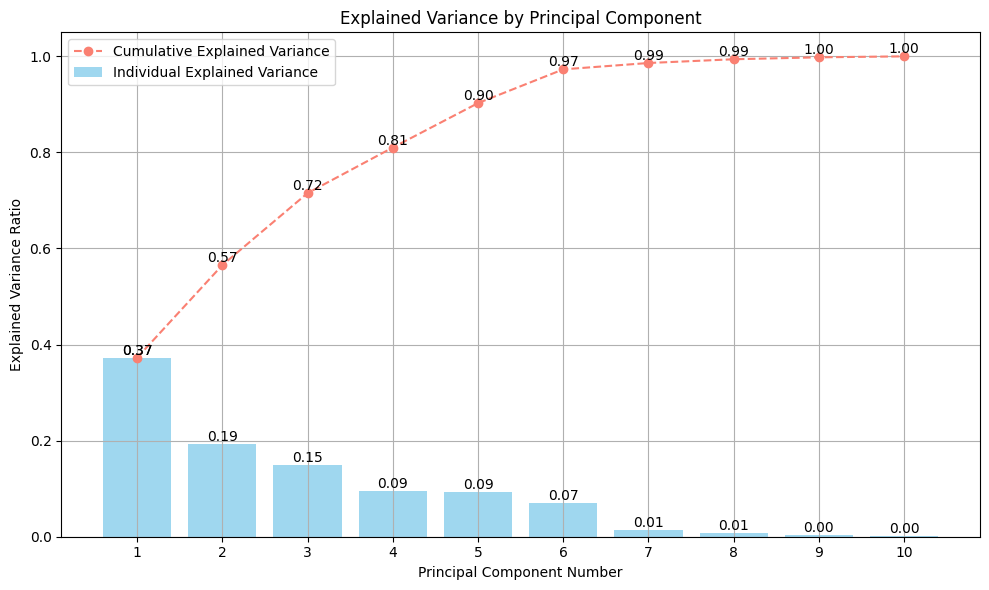

Explained variance ratio by each component:
[0.3726316  0.19281326 0.1498502  0.0949215  0.09243683 0.07029907
 0.01320277 0.0078081  0.00400652 0.00203015]

Cumulative explained variance:
[0.3726316  0.56544487 0.71529506 0.81021656 0.90265339 0.97295246
 0.98615523 0.99396333 0.99796985 1.        ]


In [6]:
pca = PCA()
Feature_PCA =  pca.fit_transform(dataset)
pca_df = pd.DataFrame(Feature_PCA, columns=[f'PC{i+1}' for i in range(Feature_PCA.shape[1])])
PCA_variance(pca)

In [ ]:
Treshold(pca, dataset.columns)

Eigenvalues: [3.72633085 1.92814031 1.49850793 0.94921874 0.924372   0.70299348
 0.13202821 0.07808129 0.04006539 0.0203016 ]
Components above eigenvalue 1: [ True  True  True False False False False False False False]
Number of components to retain: 3
Indices of significant components: [0 1 2]

PCA Results Summary:
   Component  Eigenvalue  Above Kaiser Threshold  Variance Explained  \
0          1    3.726331                    True            0.372632   
1          2    1.928140                    True            0.192813   
2          3    1.498508                    True            0.149850   
3          4    0.949219                   False            0.094921   
4          5    0.924372                   False            0.092437   
5          6    0.702993                   False            0.070299   
6          7    0.132028                   False            0.013203   
7          8    0.078081                   False            0.007808   
8          9    0.040065          


PCA Loadings (how each original feature contributes to each PC):
                    PC1       PC2       PC3       PC4       PC5       PC6  \
SET_INSP_PRES  0.474257  0.243580  0.060213 -0.036998 -0.097211 -0.063499   
SET_RR_IPPV    0.236776 -0.462262  0.422686  0.048014  0.213121 -0.034212   
TV            -0.095599  0.467625  0.493077  0.234238  0.008739 -0.381969   
PIP_MBAR       0.478375  0.242860  0.035419 -0.052516 -0.100912 -0.047313   
PEEP_MBAR      0.138943  0.264381 -0.137987 -0.174923  0.842376  0.329937   
PPLAT_MBAR     0.477655  0.245384  0.044956 -0.041783 -0.080768 -0.048095   
COMPLIANCE    -0.385759  0.271644  0.286985  0.141546  0.312936 -0.202681   
SET_INSP_TM   -0.235331  0.474702 -0.391351 -0.076334 -0.229073  0.123286   
FLOW_AIR      -0.107404  0.141708  0.530330 -0.091437 -0.258344  0.778968   
Resistance     0.133608  0.001786 -0.188425  0.933881  0.040045  0.269104   

                    PC7       PC8       PC9      PC10  
SET_INSP_PRES -0.015106  0.249

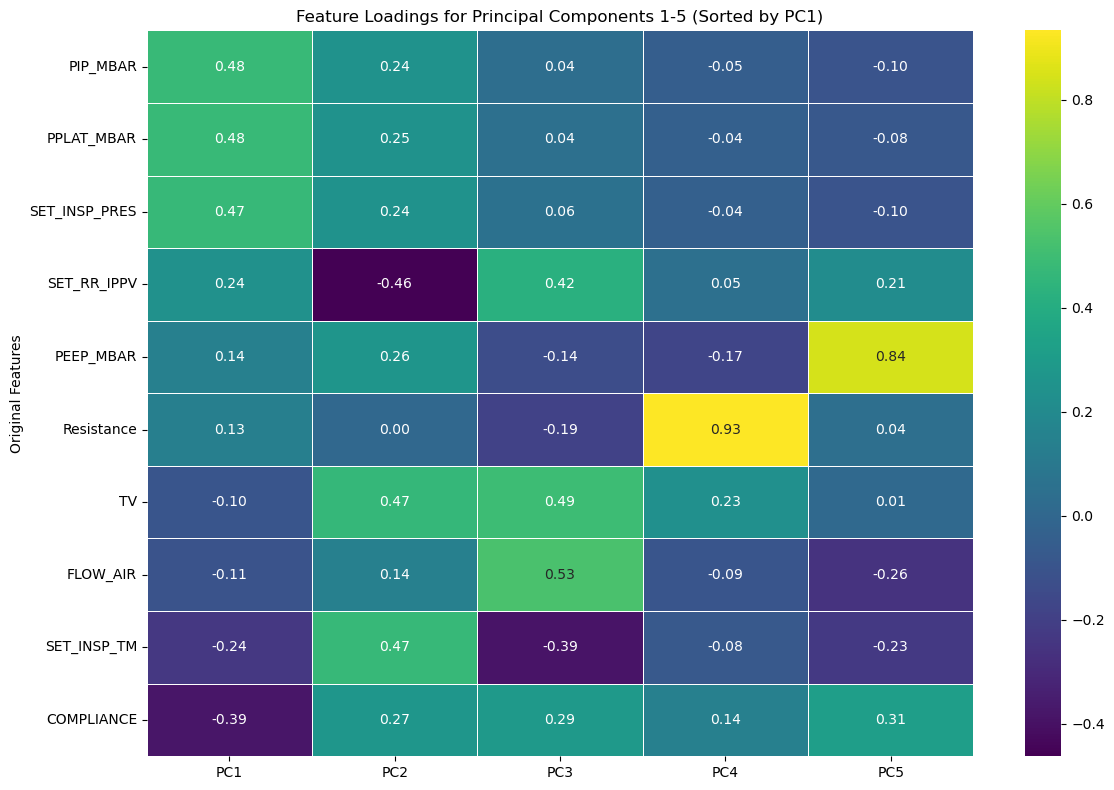

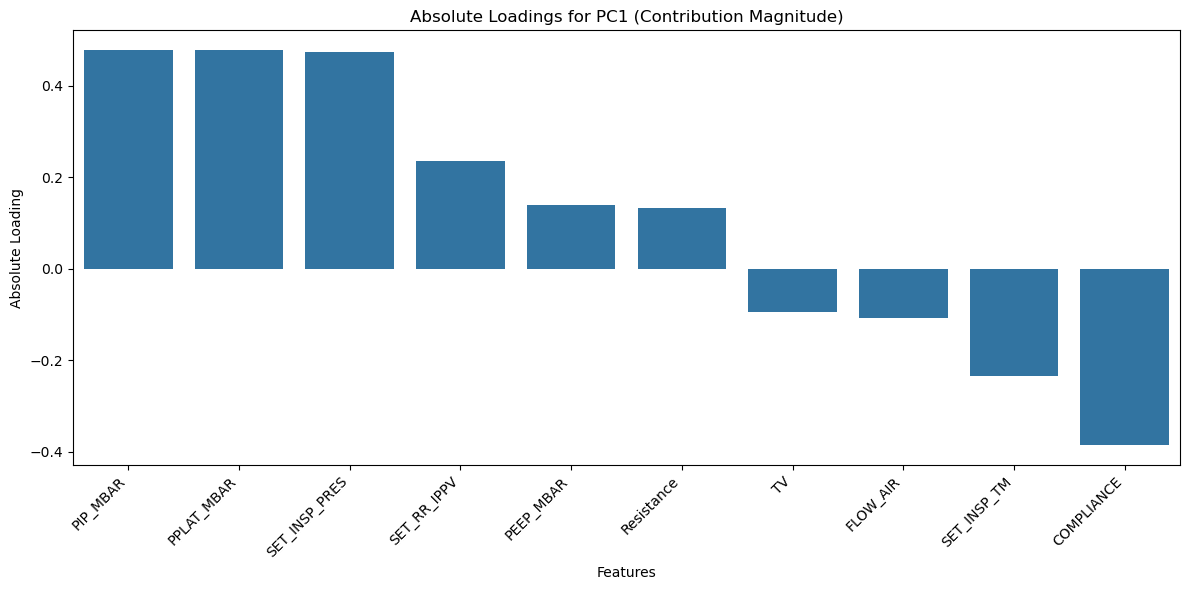

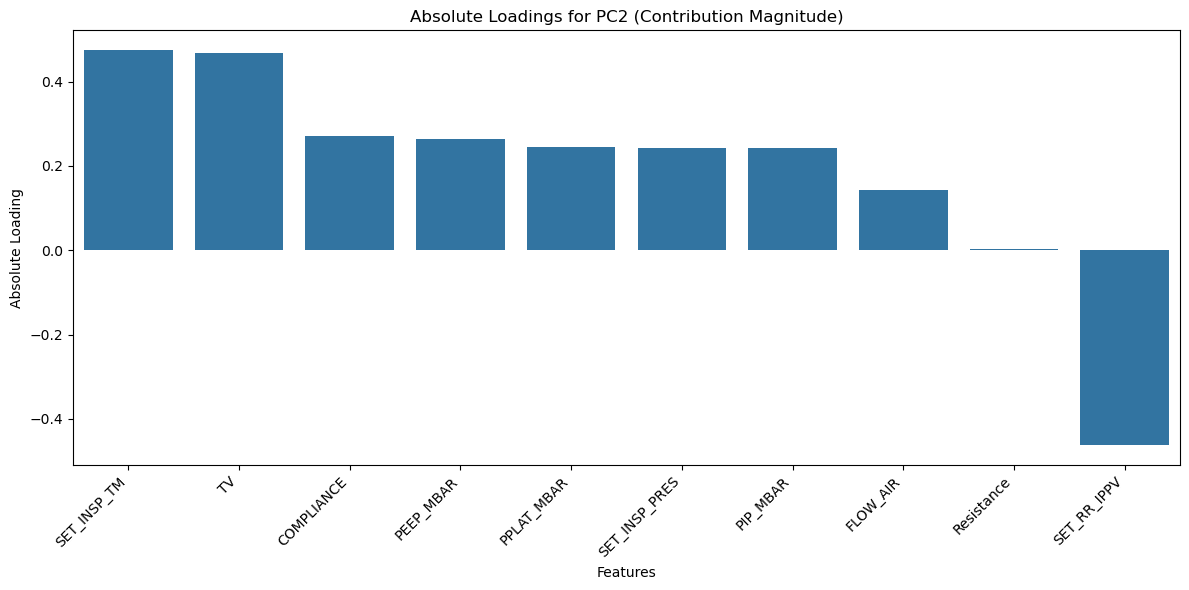

In [ ]:
LoadingsPCA(pca)

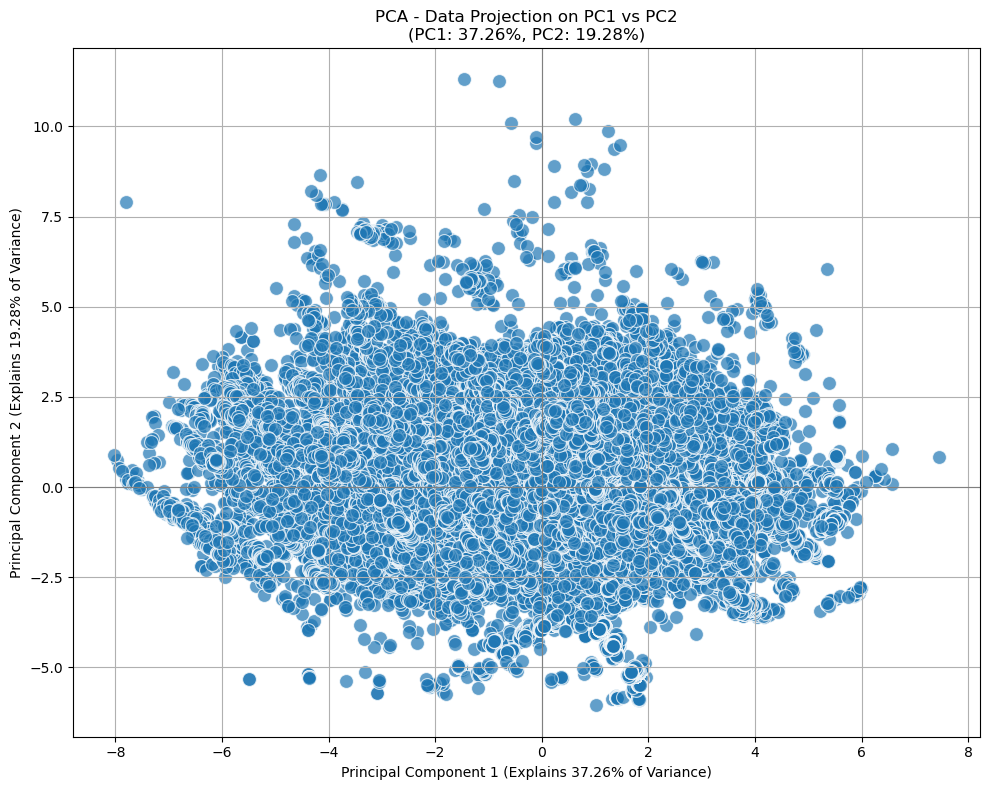

In [ ]:
plt.figure(figsize=(10, 8))
sb.scatterplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='Target_Variable' if 'Target_Variable' in pca_df.columns else None, # Color by target if available
    palette='viridis' if 'Target_Variable' in pca_df.columns else None,
    s=100,
    alpha=0.7,
    edgecolor='w'
)
plt.title(f'PCA - Data Projection on PC1 vs PC2\n(PC1: {pca.explained_variance_ratio_[0]*100:.2f}%, PC2: {pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.xlabel(f'Principal Component 1 (Explains {pca.explained_variance_ratio_[0]*100:.2f}% of Variance)')
plt.ylabel(f'Principal Component 2 (Explains {pca.explained_variance_ratio_[1]*100:.2f}% of Variance)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)
plt.tight_layout()
plt.show()

> # Uniform Manifold Approximation and Projection

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=40, min_dist=0.5, random_state=42)
# Fit and transform the data
embedding = reducer.fit_transform(dataset)
# Convert the embedding to a DataFrame for easier plotting
UMAP_dataframe = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

/home/molderon/.local/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
feature_umap_correlations = dataset.corrwith(UMAP_dataframe['UMAP_1'])
print("\nCorrelations of original features with UMAP_1:")
print(feature_umap_correlations.sort_values(ascending=False))

feature_umap_correlations_2 = dataset.corrwith(UMAP_dataframe['UMAP_2'])
print("\nCorrelations of original features with UMAP_2:")
print(feature_umap_correlations_2.sort_values(ascending=False))

# Visualize correlations (similar to loadings, but interpreted differently)
plt.figure(figsize=(12, 6))
sb.barplot(x=feature_umap_correlations.index, y=feature_umap_correlations.abs().sort_values(ascending=False).values,
            order=feature_umap_correlations.abs().sort_values(ascending=False).index, palette='coolwarm')
plt.title('Absolute Correlations of Features with UMAP Dimension 1')
plt.xlabel('Original Feature')
plt.ylabel('Absolute Correlation Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

> # Exploratory Data Analysis

In [ ]:

class ShapFeatureAnalyzer:
    def __init__(self, dataframe: pd.DataFrame,
                 model_class=xgb.XGBRegressor,
                 test_size: float = 0.2,
                 random_state: int = 42,
                 max_workers: Optional[int] = None,
                 model_params: Optional[Dict] = None,
                 use_gpu: bool = True,
                 background_samples: int = 100,
                 shap_n_jobs: int = -1):

        if not isinstance(dataframe, pd.DataFrame):
            raise ValueError("Input must be a Pandas DataFrame.")
        if dataframe.empty:
            raise ValueError("DataFrame cannot be empty.")
        if len(dataframe.columns) < 2:
            raise ValueError("DataFrame must have at least two columns.")

        self.df = dataframe.copy()
        self.model_class = model_class
        self.test_size = test_size
        self.random_state = random_state
        self.max_workers = max_workers
        self.model_params = model_params or {}
        self.use_gpu = use_gpu
        self.background_samples = background_samples
        self.shap_n_jobs = shap_n_jobs
        self.results = {}
        self.gpu_available = False

        shap.initjs()
        warnings.filterwarnings("ignore", category=UserWarning)

        if self.use_gpu:
            self._initialize_GPU()

    def _initialize_GPU(self):
        try:
            import cupy as cp
            #import cuml
            self.gpu_available = True
            print("GPU acceleration enabled")
        except ImportError:
            print("GPU libraries not available. Falling back to CPU.")
            self.gpu_available = False

    def ExportGPU_Format(self, data: Union[pd.DataFrame, pd.Series]):
        if not self.gpu_available:
            return data

        try:
            import cudf
            if isinstance(data, pd.Series):
                return cudf.Series.from_pandas(data)
            return cudf.DataFrame.from_pandas(data)
        except ImportError:
            return data

    def _get_explainer(self, model, X_train: pd.DataFrame) -> shap.Explainer:
        if self.gpu_available:
            try:
                from shap import GPUTreeExplainer
                print("Using GPU-accelerated TreeExplainer")
                return GPUTreeExplainer(model)
            except ImportError:
                pass

        if hasattr(model, 'tree_') or hasattr(model, 'get_booster'):
            return shap.TreeExplainer(model)
        else:
            print(f"Using KernelExplainer with {self.background_samples} background samples")
            background = shap.sample(X_train, self.background_samples, random_state=self.random_state)
            return shap.KernelExplainer(partial(model.predict, validate_features=False), background)

    def _train_model(self, X_train, y_train):
        params = {
            'objective': 'reg:squarederror',
            'max_depth': 20,
            'learning_rate': 0.8,
            'random_state': self.random_state,
            **self.model_params
        }

        if self.gpu_available:
            params['tree_method'] = 'gpu_hist'
            params['predictor'] = 'gpu_predictor'

        model = self.model_class(**params)
        model.fit(X_train, y_train)
        return model


    def AnalyseFeature(self, target_col: str, generate_plots: bool = True) -> Optional[Dict[str, Any]]:
        try:
            start_time = time.time()
            print(f"\n[Shap Process]: Analyzing target: '{target_col}'")

            y = self.df[target_col]
            X = self.df.drop(columns=[target_col])

            if X.empty:
                print(f"Skipping '{target_col}': No features available")
                return None

            if self.gpu_available:
                X = self.ExportGPU_Format(X)
                y = self.ExportGPU_Format(y)

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=self.test_size,
                random_state=self.random_state
            )

            model = self._train_model(X_train, y_train)
            train_time = (time.time() - start_time)/60
            print(f"Model trained in {train_time:.2f}m")

            explainer = self._get_explainer(model, X_train)

            shap_kwargs = {}
            if isinstance(explainer, shap.KernelExplainer):
                shap_kwargs['n_jobs'] = self.shap_n_jobs

            if isinstance(explainer, shap.KernelExplainer):
                X_test_values = X_test.values if hasattr(X_test, 'values') else X_test
            else:
                X_test_values = X_test

            shap_values = explainer.shap_values(X_test_values, **shap_kwargs)
            base_value = explainer.expected_value

            print(f"Rendering '{target_col}' SHAP results...\n\n")
            if generate_plots:
                self.MakePlots(target_col, shap_values, X_test, explainer)

            del X_train, y_train
            gc.collect()

            return {
                'target_col': target_col,
                'model': model,
                'explainer': explainer,
                'shap_values': shap_values,
                'X_test': X_test,
                'y_test': y_test,
                'base_value': base_value
            }

        except Exception as e:
            print(f"Error analyzing '{target_col}': {str(e)}")
            return None


    def MakePlots(self, target_col: str, shap_values: Union[np.ndarray, list],
                 X_test: pd.DataFrame, explainer: shap.Explainer):
        save_dir = os.path.join("shap_plots", target_col)
        os.makedirs(save_dir, exist_ok=True)

        # Create a single SHAP Explanation object for unified data access
        shap_explanation = explainer(X_test)

        # 1. Summary Plot (most important features first) and Tabular Data
        try:
            plt.figure(figsize=(12, 8))
            plt.title(f"SHAP Summary Plot for '{target_col}'", fontsize=16)
            shap.summary_plot(shap_explanation, plot_type="violin", show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "summary_plot.png"))
            plt.close()

            # Create and save a table for the summary plot
            mean_abs_shap = np.abs(shap_explanation.values).mean(axis=0)
            summary_data = pd.DataFrame({
                'feature_name': shap_explanation.feature_names,
                'mean_abs_shap_value': mean_abs_shap
            }).sort_values(by='mean_abs_shap_value', ascending=False).reset_index(drop=True)

            summary_table_path = os.path.join(save_dir, "summary_table.csv")
            summary_data.to_csv(summary_table_path, index=False)
            print(f"Summary plot table saved to {summary_table_path}")

        except Exception as e:
            print(f"Could not create summary plot or table: {str(e)}")

        try:
            single_explanation = shap_explanation[0]

            plt.figure(figsize=(12, 8))
            plt.title(f"Waterfall Plot for '{target_col}'", fontsize=16)
            shap.plots.waterfall(single_explanation, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "waterfall_plot.png"))
            plt.close()

            single_explanation = shap_explanation[0]
            base_value_efx = single_explanation.base_values

            final_prediction_fx = base_value_efx + single_explanation.values.sum()

            # Create a DataFrame for the final output
            metrics_df = pd.DataFrame({
                'Target Column': [target_col],
                'E[f(x)]_BaseValue': [base_value_efx],
                'f(x)_FinalPrediction': [final_prediction_fx]
            })

            metrics_csv_path = os.path.join(save_dir, "waterfall_table.csv")
            metrics_df.to_csv(metrics_csv_path, index=False)
            print(f"Model metrics E[f(x)] and f(x) saved to {metrics_csv_path}")

        except Exception as e:
            print(f"Could not create waterfall plot or table: {str(e)}")
        # 3. Force Plot
        try:
            html_file_path = os.path.join(save_dir, "force_plot.html")
            shap.save_html(html_file_path, shap.force_plot(
                explainer.expected_value,
                shap_explanation.values[0, :],
                shap_explanation.data[0, :]
            ))
            print(f"Force plot saved to {html_file_path}")
        except Exception as e:
            print(f"Could not create force plot: {str(e)}")

        gc.collect()
        try:
            num_instances_to_plot = min(50, shap_explanation.data.shape[0])
            if num_instances_to_plot > 0:
                plt.figure(figsize=(15, 10))
                plt.title(f"SHAP Heatmap for '{target_col}' (Top {num_instances_to_plot} instances)", fontsize=16)
                shap.plots.heatmap(shap_explanation[:num_instances_to_plot], show=False)
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, "heatmap_plot.png"))
                plt.close()
                print(f"Heatmap plot saved to {os.path.join(save_dir, 'heatmap_plot.png')}")
        except Exception as e:
            print(f"Could not create heatmap plot: {str(e)}")



    def FullScan(self, generate_plots: bool = True):
        all_columns = self.df.columns.tolist()
        total = len(all_columns)
        completed = 0

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {
                executor.submit(self.AnalyseFeature, col, generate_plots): col
                for col in all_columns
            }

            for future in as_completed(futures):
                target_col = futures[future]
                try:
                    result = future.result()
                    if result:
                        self.results[result['target_col']] = {
                            k: v for k, v in result.items() if k != 'target_col'
                        }
                        completed += 1
                        print(f"Completed {completed}/{total} targets")
                except Exception as e:
                    print(f"Error processing '{target_col}': {str(e)}")
                gc.collect()

        print("\nSHAP analysis completed for all targets")

    def get_results(self) -> Dict[str, Any]:
        return self.results

    def FeatureImportance(self) -> pd.DataFrame:
        if not self.results:
            print("No results available")
            return pd.DataFrame()

        chunks = []
        for target_col, data in self.results.items():
            shap_values = data['shap_values']
            X_test = data['X_test']

            if isinstance(shap_values, list):
                abs_shap = np.mean([np.abs(arr) for arr in shap_values], axis=0)
            else:
                abs_shap = np.abs(shap_values)

            mean_abs_shap = np.mean(abs_shap, axis=0)

            chunk = pd.DataFrame({
                'Feature': X_test.columns,
                f'Importance|Target={target_col}': mean_abs_shap
            })
            chunks.append(chunk.set_index('Feature'))

        result_df = pd.concat(chunks, axis=1).fillna(0)
        return result_df


    def combileSHAP(self, save_path: str = "CombinedSHAP.png"):
        combined_df = pd.DataFrame()

        # Walk through the directory to find all wf_table.csv files
        for root, dirs, files in os.walk("shap_plots"):
            for file in files:
                if file == "waterfall_table.csv":
                    try:
                        file_path = os.path.join(root, file)
                        df = pd.read_csv(file_path)
                        # Extract the target column name from the path
                        target_col = os.path.basename(root)
                        df['Target Column'] = target_col
                        combined_df = pd.concat([combined_df, df], ignore_index=True)
                    except Exception as e:
                        print(f"Error reading file {file_path}: {e}")

        if combined_df.empty:
            print("No waterfall tables found to combine.")
            return

        # Prepare the table for plotting
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.axis('off')
        ax.axis('tight')

        table = ax.table(cellText=combined_df.values,
                         colLabels=combined_df.columns,
                         loc='center')

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

        plt.title("Combined Waterfall Plot Tables", fontsize=16)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        print(f"Combined waterfall tables saved as an image to {save_path}")



    def SaveResults(self, path: str):
        import joblib
        joblib.dump(self.results, path)
        print(f"Results saved to {path}")

    @classmethod
    def LoadResults(cls, path: str):
        import joblib
        return joblib.load(path)

In [ ]:
analyzer = ShapFeatureAnalyzer(dataset, model_class=xgb.XGBRegressor, random_state=42, use_gpu=True)
analyzer.FullScan(generate_plots=True)
analyzer.combileSHAP()

GPU libraries not available. Falling back to CPU.

[Shap Process]: Analyzing target: 'SET_INSP_PRES'

[Shap Process]: Analyzing target: 'SET_RR_IPPV'

[Shap Process]: Analyzing target: 'TV'

[Shap Process]: Analyzing target: 'PIP_MBAR'

[Shap Process]: Analyzing target: 'PEEP_MBAR'

[Shap Process]: Analyzing target: 'PPLAT_MBAR'

[Shap Process]: Analyzing target: 'COMPLIANCE'

[Shap Process]: Analyzing target: 'SET_INSP_TM'

[Shap Process]: Analyzing target: 'FLOW_AIR'

[Shap Process]: Analyzing target: 'Resistance'
Model trained in 0.03m
Model trained in 0.04m
Model trained in 0.09m
Model trained in 0.13m
Model trained in 0.23m
Model trained in 0.31m
Model trained in 0.33m
Model trained in 0.43m
Model trained in 0.48m
Model trained in 0.94m
Rendering 'Resistance' SHAP results...


Rendering 'FLOW_AIR' SHAP results...


Could not create decision plot: The feature_names arg requires a list or numpy array.
Force plot saved to shap_plots/Resistance/force_plot.html
Completed 1/10 targets
C

In [ ]:
dataset = GiveMeData(ScaleMe=False,TimeStepPlease=False)

In [ ]:
features = [
    'SET_INSP_PRES','SET_RR_IPPV','TV',
    'PIP_MBAR',	'PEEP_MBAR', 'PPLAT_MBAR',
    'COMPLIANCE', 'SET_INSP_TM','FLOW_AIR',
    'Resistance'
]

# --- Global Plotting Settings ---
sb.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust figure resolution for better quality
pd.set_option('display.max_columns', None) # Display all columns for describe()



# --- EDA Functions ---

def ExploreFeature(dataset: pd.DataFrame, feature_name: str):
    """
    Performs and displays summary statistics and distribution plots
    for a single numerical feature.
    """
    if feature_name not in dataset.columns:
        print(f"Error: Feature '{feature_name}' not found in DataFrame.")
        return

    print(f"\n--- Analyzing Feature: '{feature_name}' ---")

    # A. Summary Statistics
    print(f"\nSummary Statistics for '{feature_name}':")
    print(dataset[feature_name].describe())

    # B. Visualizations (Histogram & Box Plot)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sb.histplot(dataset[feature_name], kde=True, bins='auto', color='skyblue')
    plt.title(f'Distribution of {feature_name}', fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(1, 2, 2)
    sb.boxplot(y=dataset[feature_name], color='lightcoral')
    plt.title(f'Box Plot of {feature_name}', fontsize=14)
    plt.ylabel(feature_name, fontsize=12)
    plt.grid(axis='y', alpha=0.75)

    plt.tight_layout(pad=3.0)
    plt.show()



def ScatteredCorelations(dataset: pd.DataFrame, target_feature: str, other_features: list):
    """
    Plots scatter plots for the target feature against its top correlated
    subsequent parameters.
    """
    if target_feature not in dataset.columns:
        print(f"Error: Target feature '{target_feature}' not found in DataFrame.")
        return

    # Filter other_features to ensure they exist in dataset and are numerical
    valid_other_features = [f for f in other_features if f in dataset.columns and pd.api.types.is_numeric_dtype(dataset[f])]
    if not valid_other_features:
        print(f"No valid numerical 'other features' to plot against '{target_feature}'.")
        return

    # Calculate correlations and select top 3 (excluding self-correlation)
    correlations = dataset[[target_feature] + valid_other_features].corr()[target_feature].abs().sort_values(ascending=False)
    # Exclude the target_feature itself from the list
    top_correlated = correlations.drop(target_feature).index.tolist()[:3]

    if not top_correlated:
        print(f"No correlated features found for '{target_feature}' to plot scatter plots.")
        return

    print(f"\n--- Scatter Plots for '{target_feature}' vs. Top Correlated Features ---")
    num_plots = len(top_correlated)
    ncols = min(num_plots, 3) # Max 3 columns for plots
    nrows = (num_plots + ncols - 1) // ncols # Calculate rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten() # Flatten for easy iteration

    for i, feature in enumerate(top_correlated):
        sb.scatterplot(x=feature, y=target_feature, data=dataset, ax=axes[i], alpha=0.7, color='teal')
        axes[i].set_title(f'{target_feature} vs. {feature}', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel(target_feature, fontsize=10)
        axes[i].grid(True, linestyle='--', alpha=0.6)

    for j in range(i + 1, len(axes)): # Hide any unused subplots
        fig.delaxes(axes[j])

    plt.tight_layout(pad=3.0)
    plt.show()



def GroupedAnalysis(dataset: pd.DataFrame, primary_feature: str, grouping_feature: str, num_bins: int = 4):

    if primary_feature not in dataset.columns or grouping_feature not in dataset.columns:
        print(f"Error: One or both features ('{primary_feature}', '{grouping_feature}') not found in DataFrame.")
        return
    if not pd.api.types.is_numeric_dtype(dataset[primary_feature]) or not pd.api.types.is_numeric_dtype(dataset[grouping_feature]):
        print(f"Error: Both '{primary_feature}' and '{grouping_feature}' must be numerical for this analysis.")
        return

    print(f"\n--- Grouped Analysis: '{primary_feature}' by Bins of '{grouping_feature}' ---")

    # Create bins for the grouping feature
    grouping_col_binned_name = f'{grouping_feature}_Binned_Q{num_bins}'
    try:
        dataset[grouping_col_binned_name] = pd.qcut(dataset[grouping_feature], q=num_bins, duplicates='drop',
                                                     labels=[f'Q{i+1}' for i in range(num_bins) if i < dataset[grouping_feature].nunique()])
    except Exception as e:
        print(f"Could not create bins for '{grouping_feature}'. Error: {e}")
        print(f"Unique values in '{grouping_feature}': {dataset[grouping_feature].nunique()}")
        print("Skipping grouped analysis for this pair.")
        return

    # Filter out any NaN groups that might result from qcut if data distribution is problematic
    filtered_df = dataset.dropna(subset=[grouping_col_binned_name]).copy()
    if filtered_df.empty:
        print(f"No valid data points after binning '{grouping_feature}'. Skipping grouped analysis.")
        return

    # Summary statistics of primary_feature by grouping_feature bins
    print(f"\nSummary Statistics of '{primary_feature}' by '{grouping_feature}' Bins:")
    print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())

    # Box plot
    plt.figure(figsize=(10, 6))
    sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')
    plt.title(f'{primary_feature} Distribution by {grouping_feature} Groups', fontsize=14)
    plt.xlabel(f'{grouping_feature} Quantile Groups', fontsize=12)
    plt.ylabel(primary_feature, fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Violin plot (provides more detail on distribution shape)
    plt.figure(figsize=(10, 6))
    sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')
    plt.title(f'{primary_feature} Distribution (Violin Plot) by {grouping_feature} Groups', fontsize=14)
    plt.xlabel(f'{grouping_feature} Quantile Groups', fontsize=12)
    plt.ylabel(primary_feature, fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Clean up the temporary binned column
    dataset.drop(columns=[grouping_col_binned_name], inplace=True, errors='ignore')

In [ ]:
# A. Correlation Heatmap for all features
def EDA(dataset:pd.DataFrame):
    print("\nCorrelation Matrix of All Features:")
    correlation_matrix = dataset[features].corr()
    print(correlation_matrix)

    plt.figure(figsize=(12, 10))
    sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 10})
    plt.title('Correlation Matrix of All Features', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nPair Plot of All Features:")

    sb.pairplot(dataset[features], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red', 'alpha':0.7}}, corner=True)
    plt.suptitle('Pair Plot of All Physiological Parameters', y=1.02, fontsize=16)
    plt.show()
    print("-" * 50)


    # --- Loop Through Each Feature for Detailed Analysis ---
    for feature in features:
        print(f"\n\n{'='*20} DETAILED ANALYSIS FOR FEATURE: {feature} {'='*20}")

        # 1. Individual Feature Analysis (Summary & Distribution)
        ExploreFeature(dataset, feature)

        # 2. Scatter Plots against top correlated other features
        ScatterdFeatures = [f for f in features if f != feature]
        ScatteredCorelations(dataset, feature, ScatterdFeatures)

        print(f"\n--- Exploring how '{feature}' is influenced by other features (Grouped Analysis) ---")

        # Get correlations of the current 'feature' with all other features
        if feature in correlation_matrix.index:
            current_feature_correlations = correlation_matrix[feature].abs().sort_values(ascending=False)
            # Select top 2 other features (excluding itself) for grouped analysis
            top_grouping_candidates = current_feature_correlations.drop(feature, errors='ignore').index.tolist()[:2]
        else:
            top_grouping_candidates = [] # Should not happen if features is consistent

        if not top_grouping_candidates:
            print(f"No suitable grouping features found for '{feature}'.")

        for grouping_feat in top_grouping_candidates:
            GroupedAnalysis(dataset, primary_feature=feature, grouping_feature=grouping_feat, num_bins=4)

        print(f"\n{'='*20} END OF ANALYSIS FOR FEATURE: {feature} {'='*20}\n")

    print("\n\n--- All EDA Complete ---")


Correlation Matrix of All Features:
               SET_INSP_PRES  SET_RR_IPPV        TV  PIP_MBAR  PEEP_MBAR  \
SET_INSP_PRES       1.000000     0.218869  0.093613  0.969279   0.270206   
SET_RR_IPPV         0.218869     1.000000 -0.166988  0.208543  -0.052142   
TV                  0.093613    -0.166988  1.000000  0.065572  -0.024772   
PIP_MBAR            0.969279     0.208543  0.065572  1.000000   0.279827   
PEEP_MBAR           0.270206    -0.052142 -0.024772  0.279827   1.000000   
PPLAT_MBAR          0.959920     0.214553  0.082971  0.977153   0.293957   
COMPLIANCE         -0.540866    -0.325309  0.650538 -0.562132   0.041002   
SET_INSP_TM        -0.211732    -0.864578  0.171914 -0.195937   0.062580   
FLOW_AIR           -0.083175     0.034840  0.325006 -0.093880  -0.098622   
Resistance          0.171873     0.041552 -0.050411  0.170214   0.047244   

               PPLAT_MBAR  COMPLIANCE  SET_INSP_TM  FLOW_AIR  Resistance  
SET_INSP_PRES    0.959920   -0.540866    -0.211732 

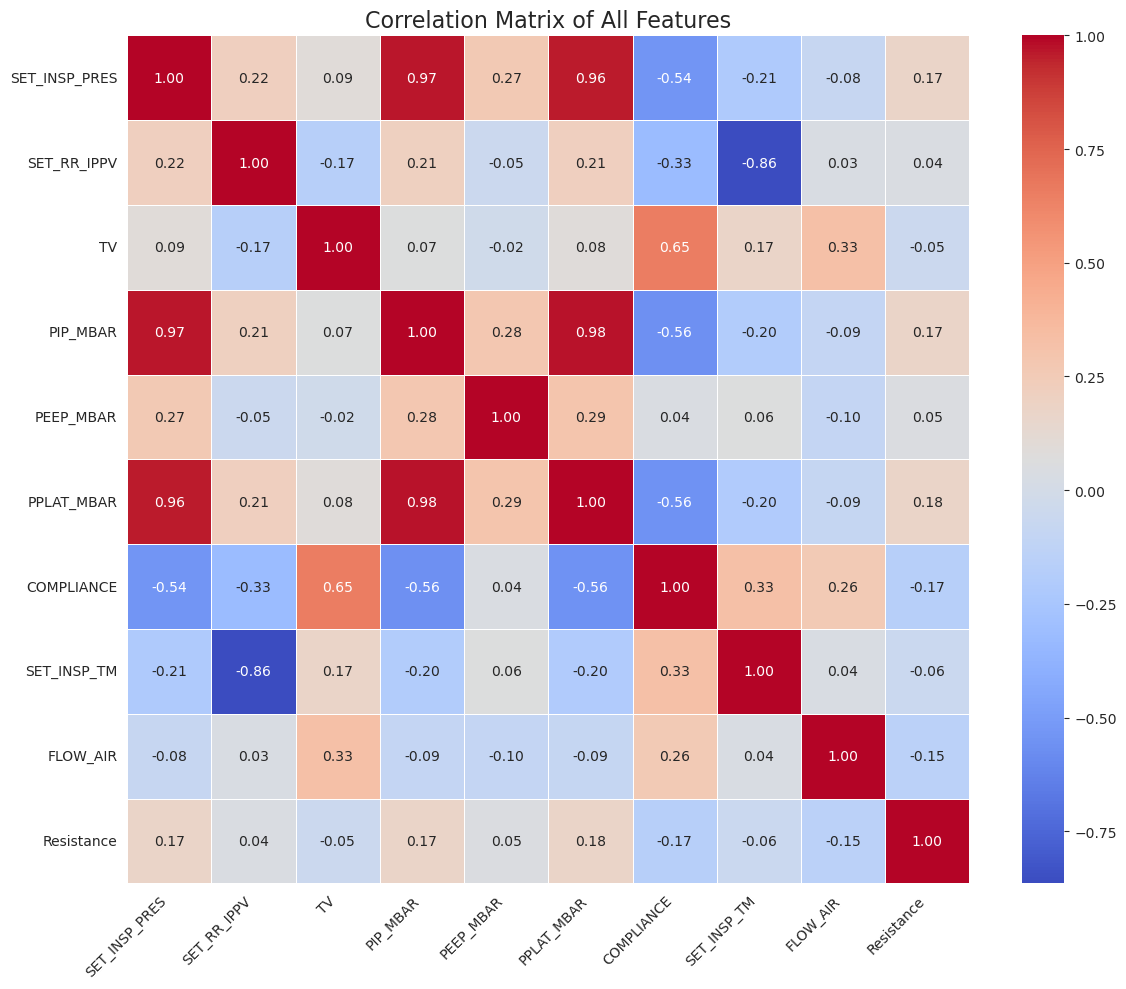


Pair Plot of All Features:


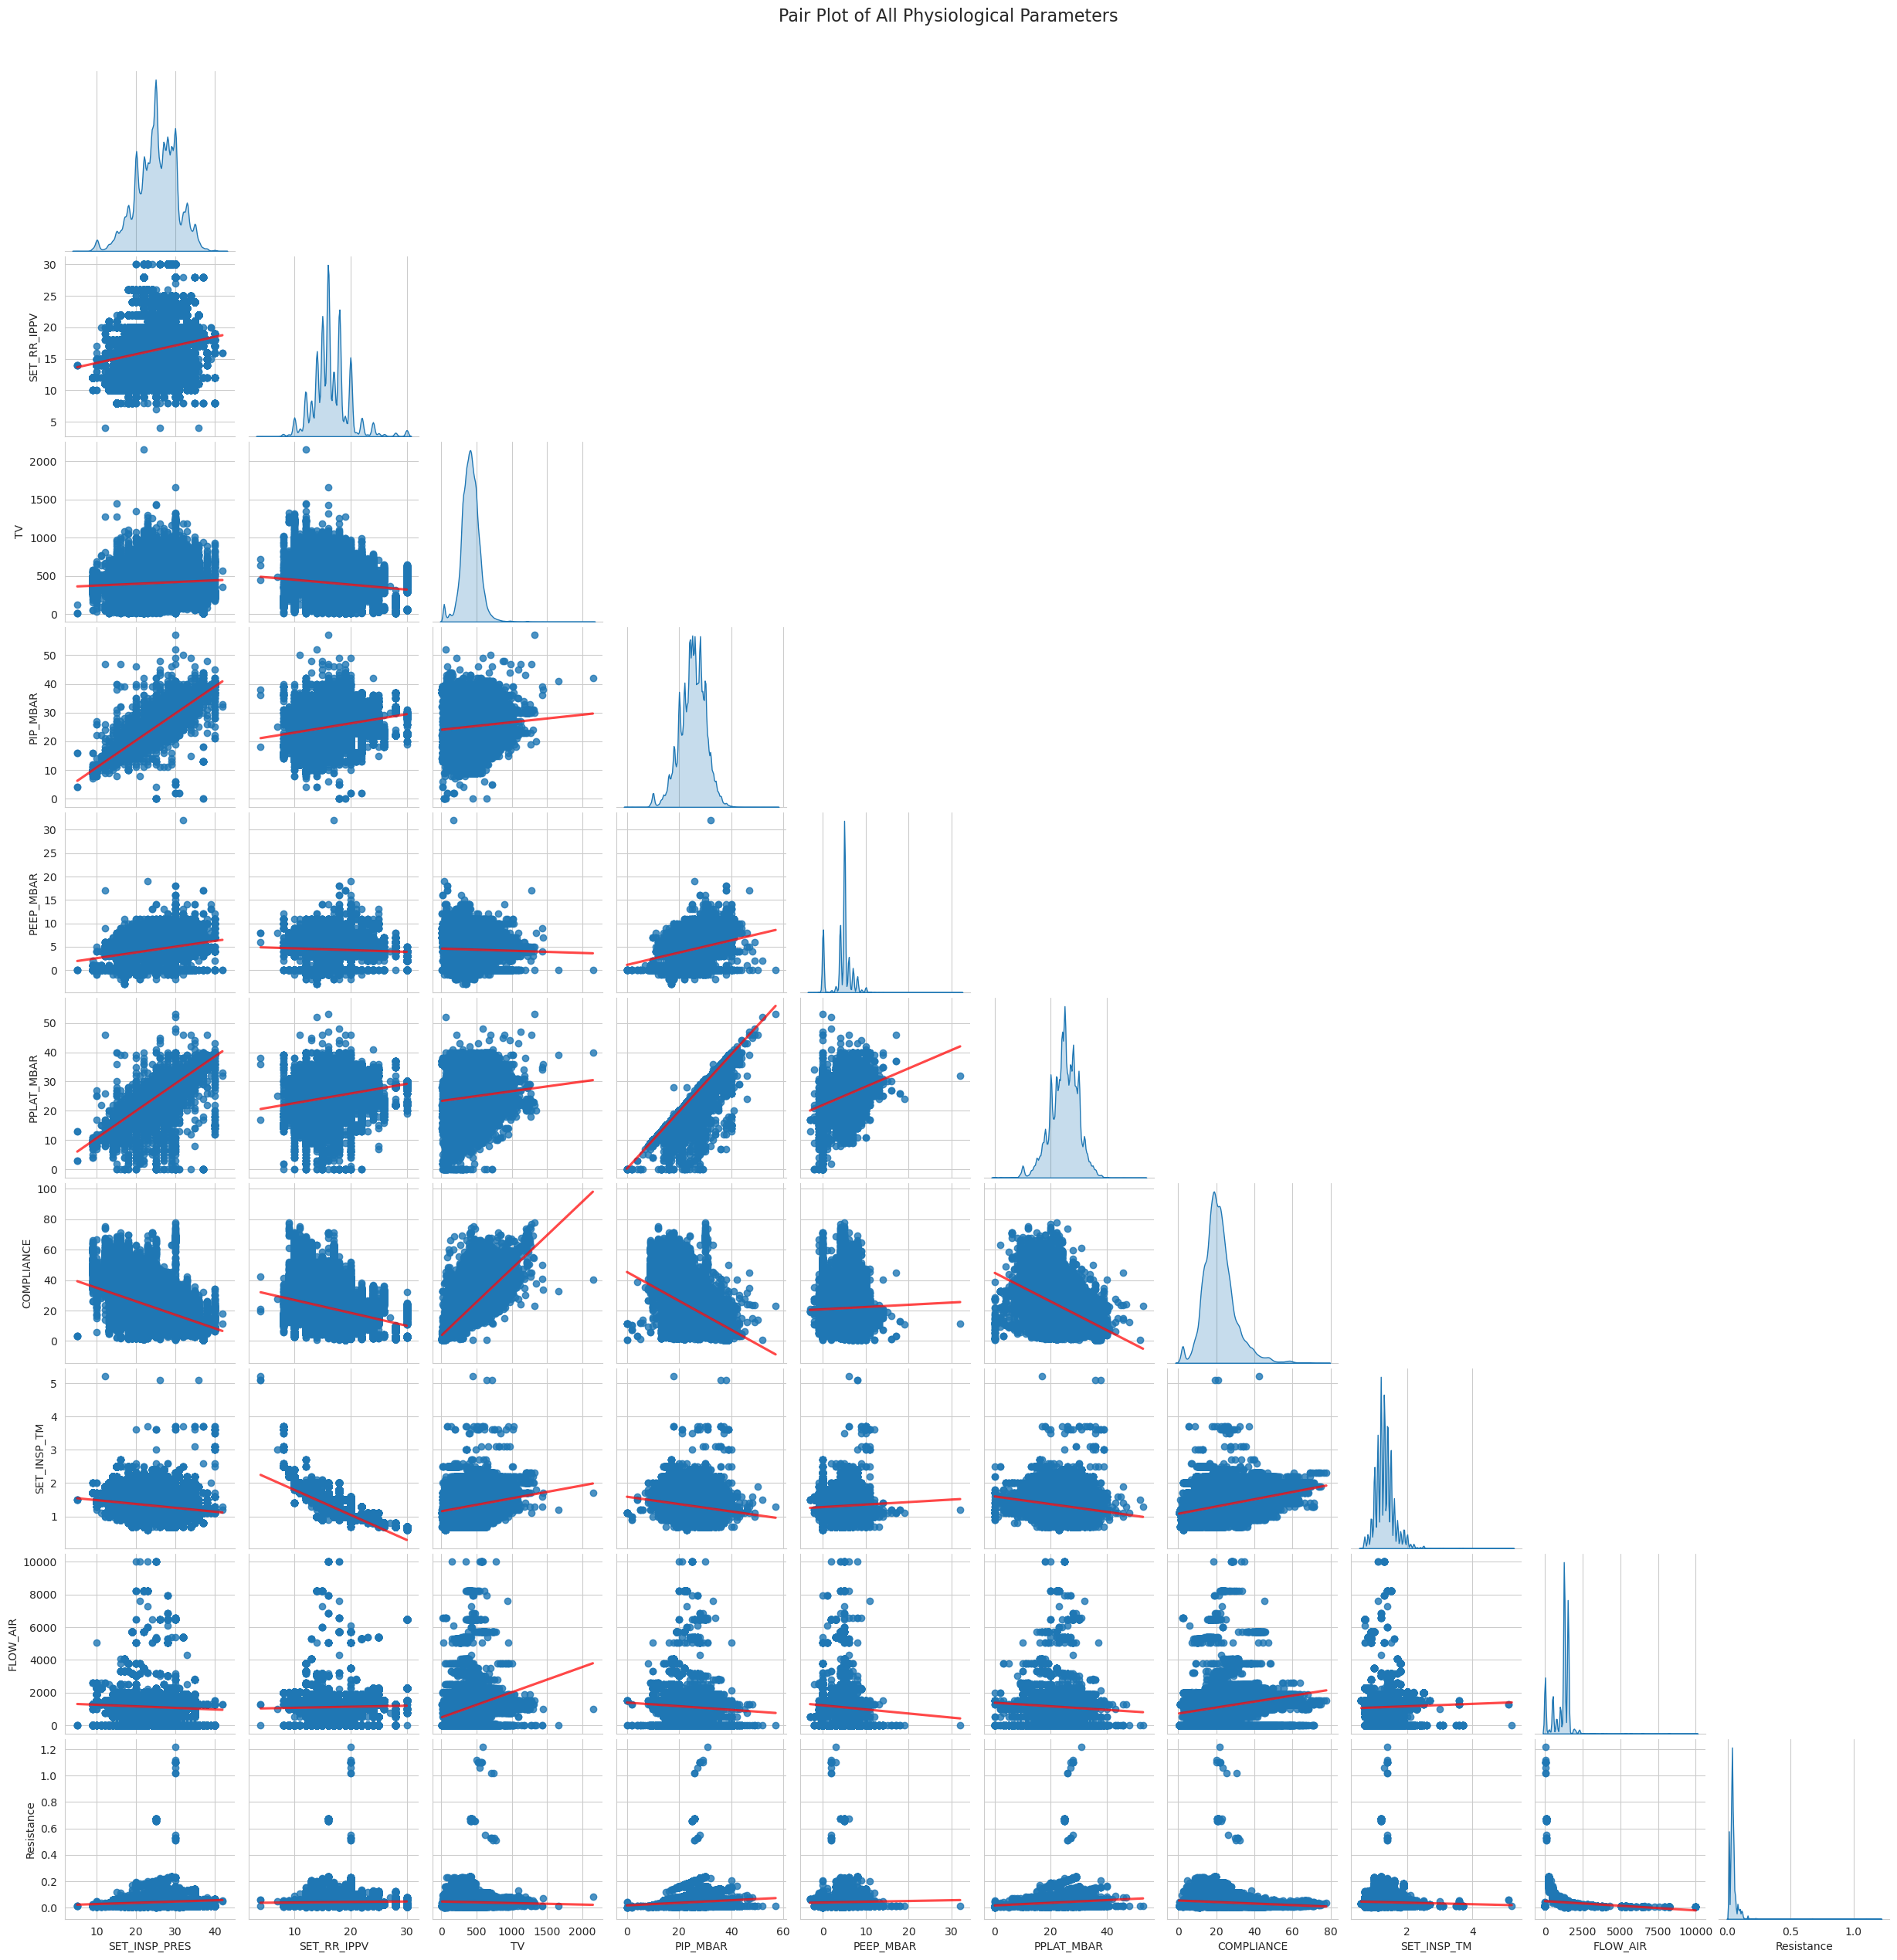

--------------------------------------------------


==================== DETAILED ANALYSIS FOR FEATURE: SET_INSP_PRES ====================

--- Analyzing Feature: 'SET_INSP_PRES' ---

Summary Statistics for 'SET_INSP_PRES':
count    251237.000000
mean         25.136409
std           5.052927
min           5.000000
25%          22.000000
50%          25.000000
75%          29.000000
max          42.000000
Name: SET_INSP_PRES, dtype: float64


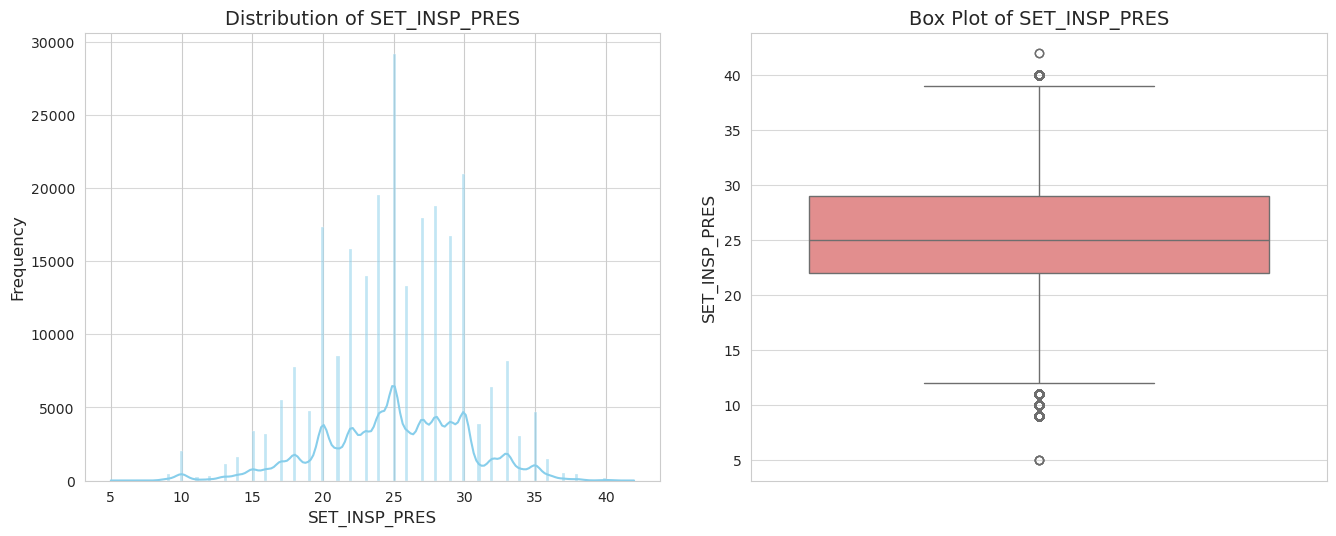


--- Scatter Plots for 'SET_INSP_PRES' vs. Top Correlated Features ---


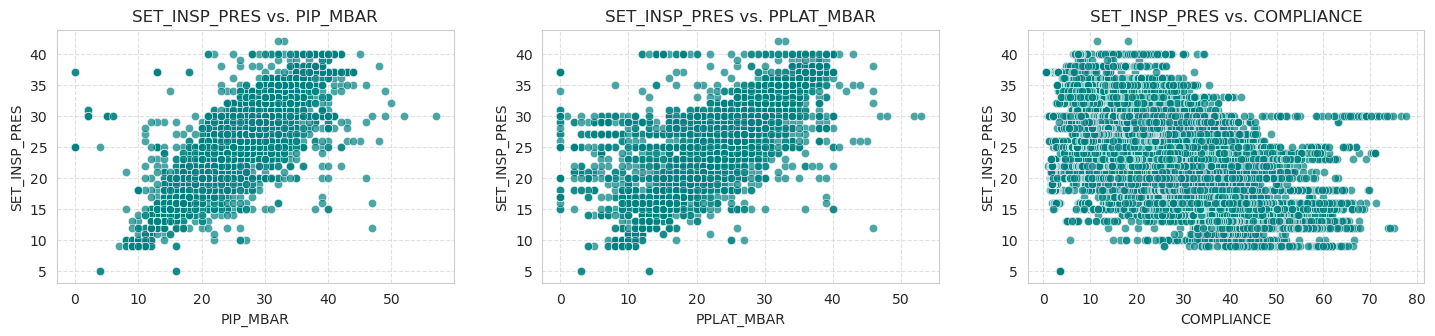


--- Exploring how 'SET_INSP_PRES' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'SET_INSP_PRES' by Bins of 'PIP_MBAR' ---

Summary Statistics of 'SET_INSP_PRES' by 'PIP_MBAR' Bins:
                      count       mean       std   min   25%   50%   75%   max
PIP_MBAR_Binned_Q4                                                            
Q1                  70831.0  18.995256  3.060052   5.0  17.0  20.0  21.0  40.0
Q2                  58227.0  24.295688  1.376165  12.0  23.0  24.0  25.0  40.0
Q3                  61478.0  27.068431  1.562639  10.0  26.0  27.0  28.0  40.0
Q4                  60701.0  31.152123  2.409165  12.0  29.0  30.0  33.0  42.0


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


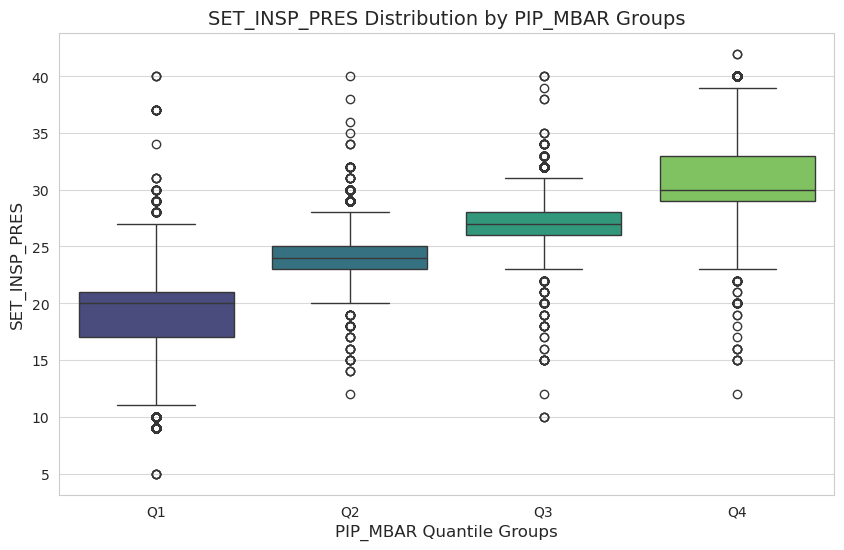

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


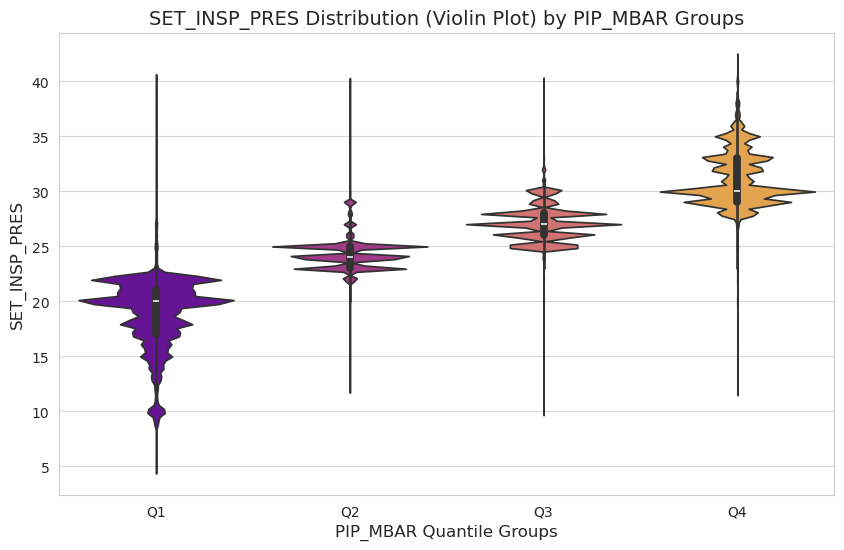


--- Grouped Analysis: 'SET_INSP_PRES' by Bins of 'PPLAT_MBAR' ---

Summary Statistics of 'SET_INSP_PRES' by 'PPLAT_MBAR' Bins:
                        count       mean       std   min   25%   50%   75%  \
PPLAT_MBAR_Binned_Q4                                                         
Q1                    74694.0  19.239792  3.231603   5.0  18.0  20.0  22.0   
Q2                    66567.0  24.553007  1.336716  10.0  24.0  25.0  25.0   
Q3                    55883.0  27.596210  1.413793  10.0  27.0  27.0  28.0   
Q4                    54093.0  31.455456  2.299595  12.0  30.0  31.0  33.0   

                       max  
PPLAT_MBAR_Binned_Q4        
Q1                    40.0  
Q2                    40.0  
Q3                    40.0  
Q4                    42.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


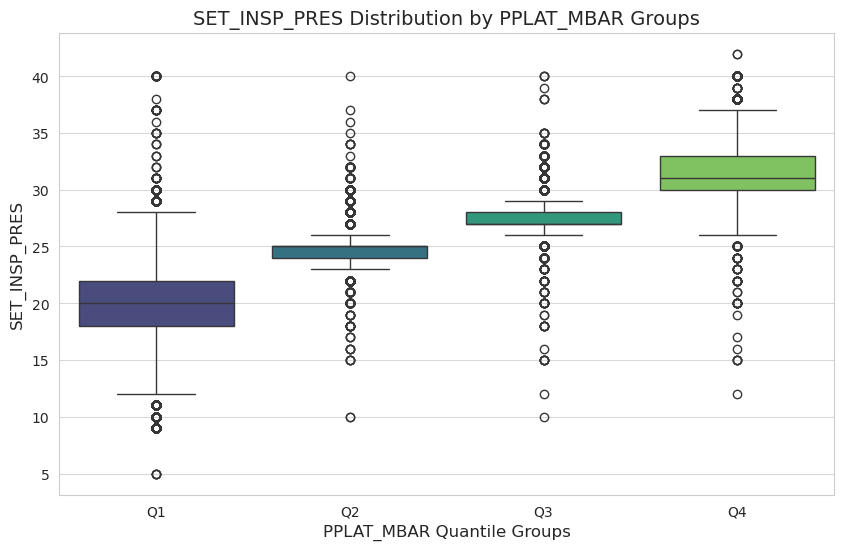

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


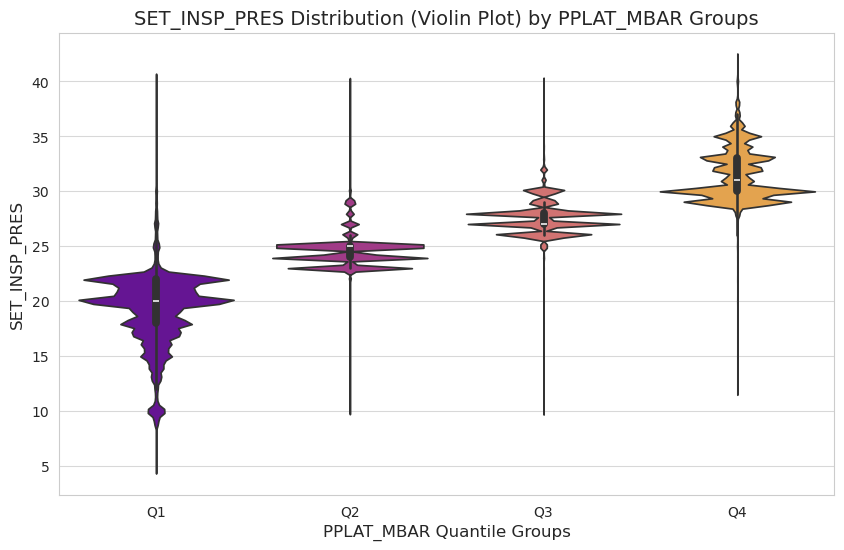


==================== END OF ANALYSIS FOR FEATURE: SET_INSP_PRES ====================



==================== DETAILED ANALYSIS FOR FEATURE: SET_RR_IPPV ====================

--- Analyzing Feature: 'SET_RR_IPPV' ---

Summary Statistics for 'SET_RR_IPPV':
count    251237.000000
mean         16.441340
std           3.172461
min           4.000000
25%          15.000000
50%          16.000000
75%          18.000000
max          30.000000
Name: SET_RR_IPPV, dtype: float64


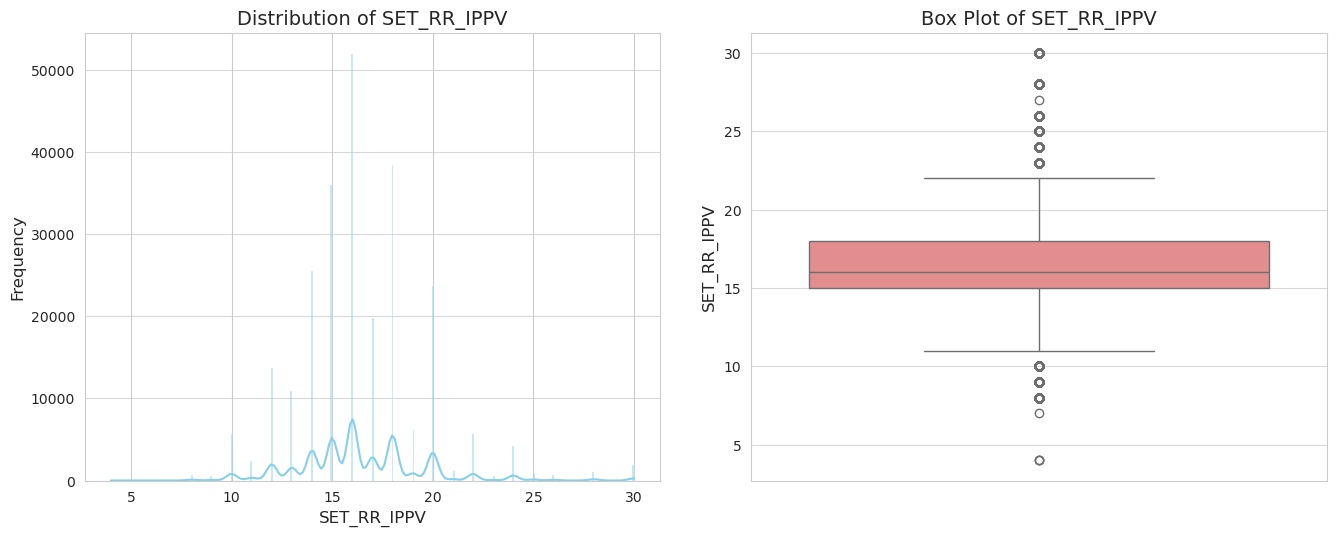


--- Scatter Plots for 'SET_RR_IPPV' vs. Top Correlated Features ---


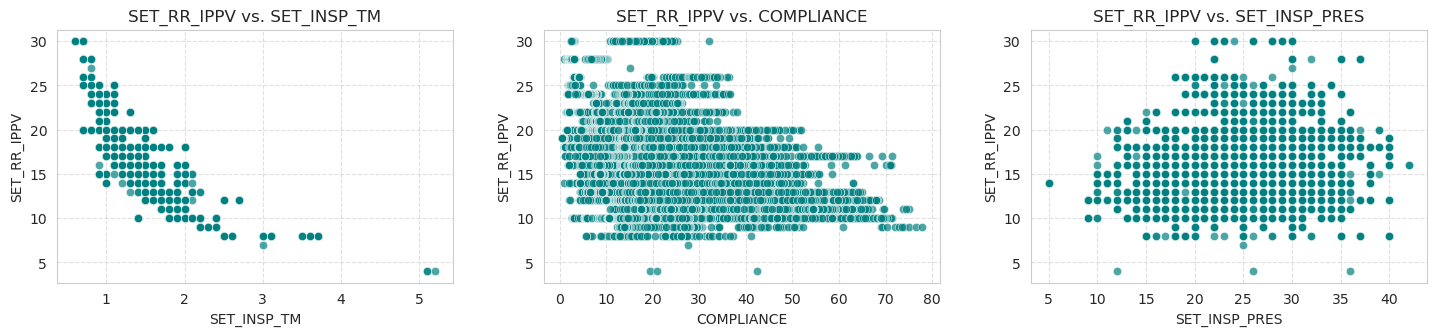


--- Exploring how 'SET_RR_IPPV' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'SET_RR_IPPV' by Bins of 'SET_INSP_TM' ---

Summary Statistics of 'SET_RR_IPPV' by 'SET_INSP_TM' Bins:
                         count       mean       std   min   25%   50%   75%  \
SET_INSP_TM_Binned_Q4                                                         
Q1                     66567.0  20.115117  2.802540  14.0  18.0  20.0  20.0   
Q2                     85241.0  16.519421  1.030620  13.0  16.0  16.0  17.0   
Q3                     62076.0  14.837941  1.205636  10.0  14.0  15.0  15.0   
Q4                     37353.0  12.380746  2.007556   4.0  12.0  12.0  13.0   

                        max  
SET_INSP_TM_Binned_Q4        
Q1                     30.0  
Q2                     22.0  
Q3                     20.0  
Q4                     20.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


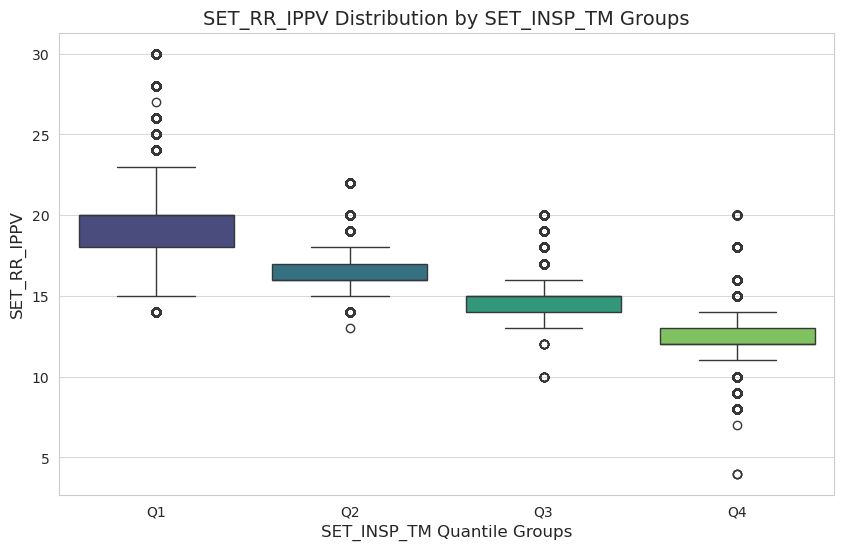

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


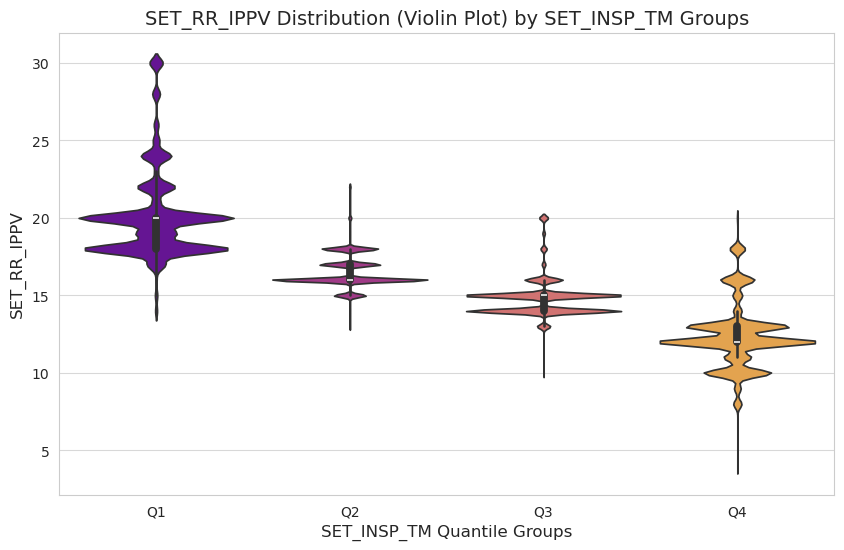


--- Grouped Analysis: 'SET_RR_IPPV' by Bins of 'COMPLIANCE' ---

Summary Statistics of 'SET_RR_IPPV' by 'COMPLIANCE' Bins:
                        count       mean       std  min   25%   50%   75%  \
COMPLIANCE_Binned_Q4                                                        
Q1                    64106.0  17.607962  3.414462  8.0  16.0  18.0  20.0   
Q2                    61698.0  16.501021  2.818825  4.0  15.0  16.0  18.0   
Q3                    62942.0  16.426694  2.854131  4.0  15.0  16.0  18.0   
Q4                    62491.0  15.200397  3.084476  4.0  13.0  15.0  17.0   

                       max  
COMPLIANCE_Binned_Q4        
Q1                    30.0  
Q2                    30.0  
Q3                    30.0  
Q4                    30.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


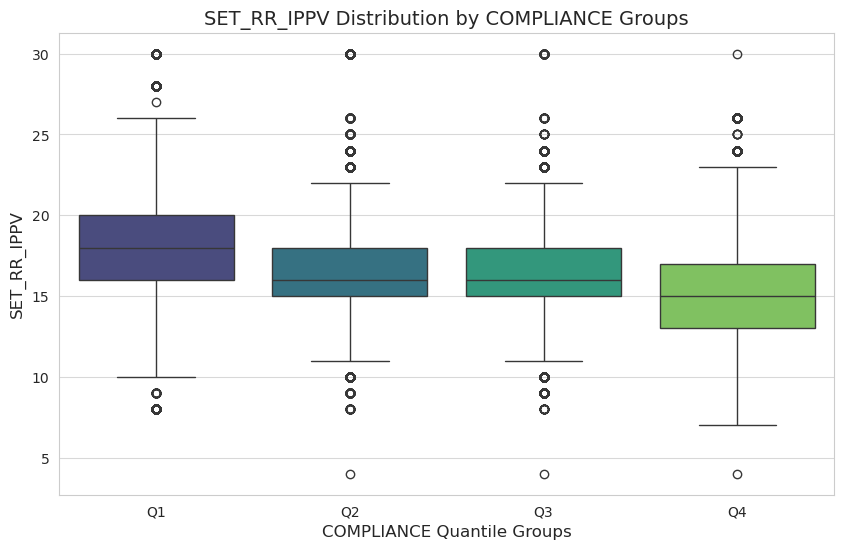

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


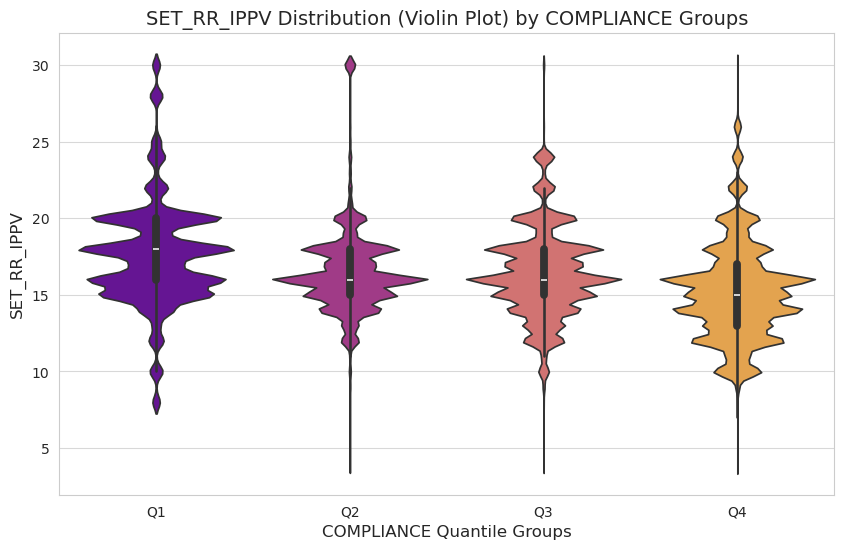


==================== END OF ANALYSIS FOR FEATURE: SET_RR_IPPV ====================



==================== DETAILED ANALYSIS FOR FEATURE: TV ====================

--- Analyzing Feature: 'TV' ---

Summary Statistics for 'TV':
count    251237.000000
mean        410.251285
std         121.951475
min          12.000000
25%         336.000000
50%         409.000000
75%         484.000000
max        2150.000000
Name: TV, dtype: float64


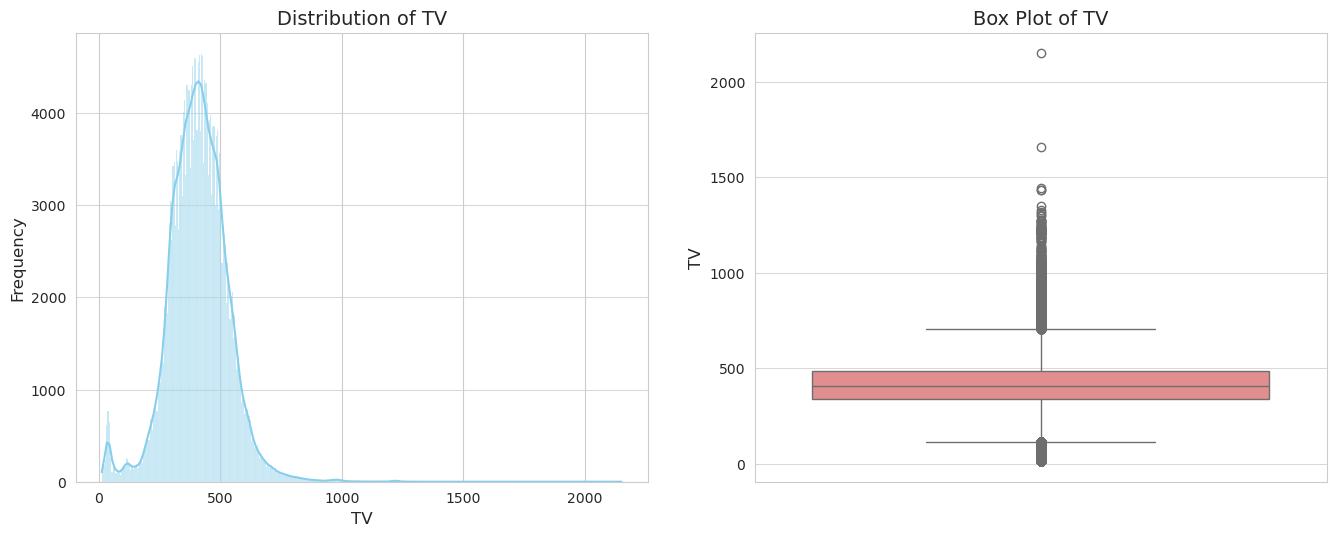


--- Scatter Plots for 'TV' vs. Top Correlated Features ---


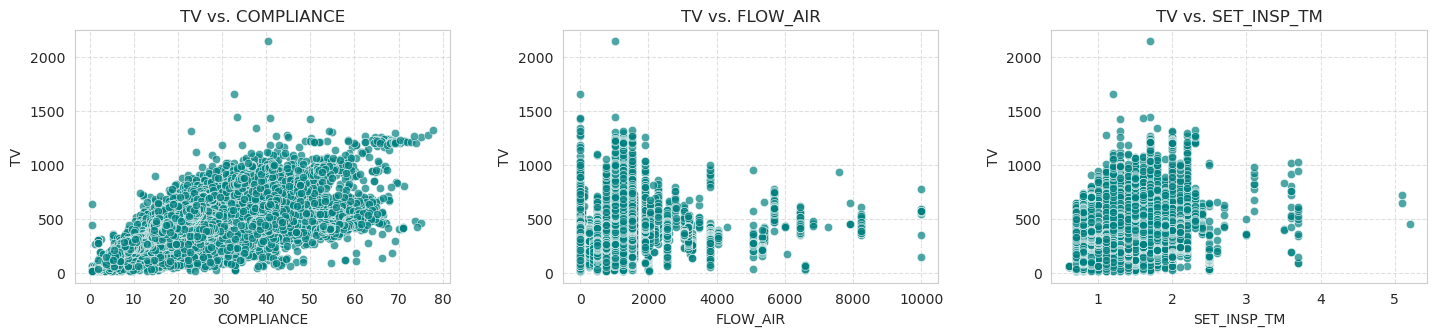


--- Exploring how 'TV' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'TV' by Bins of 'COMPLIANCE' ---

Summary Statistics of 'TV' by 'COMPLIANCE' Bins:
                        count        mean         std   min    25%    50%  \
COMPLIANCE_Binned_Q4                                                        
Q1                    64106.0  290.831935   95.368787  12.0  253.0  304.0   
Q2                    61698.0  409.403530   73.733592  41.0  360.0  404.0   
Q3                    62942.0  446.919879   85.169914  18.0  393.0  445.0   
Q4                    62491.0  496.660639  119.735779  20.0  421.0  488.0   

                        75%     max  
COMPLIANCE_Binned_Q4                 
Q1                    350.0   896.0  
Q2                    455.0   823.0  
Q3                    501.0  1318.0  
Q4                    556.0  2150.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


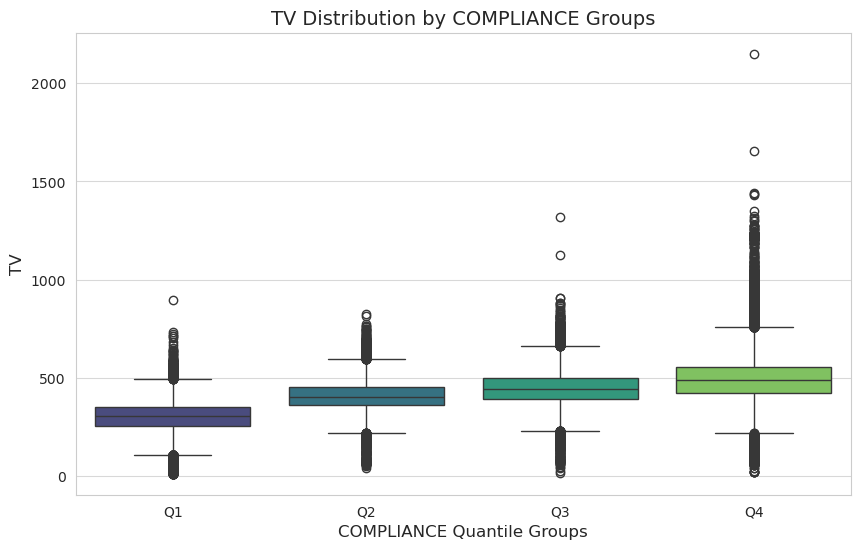

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


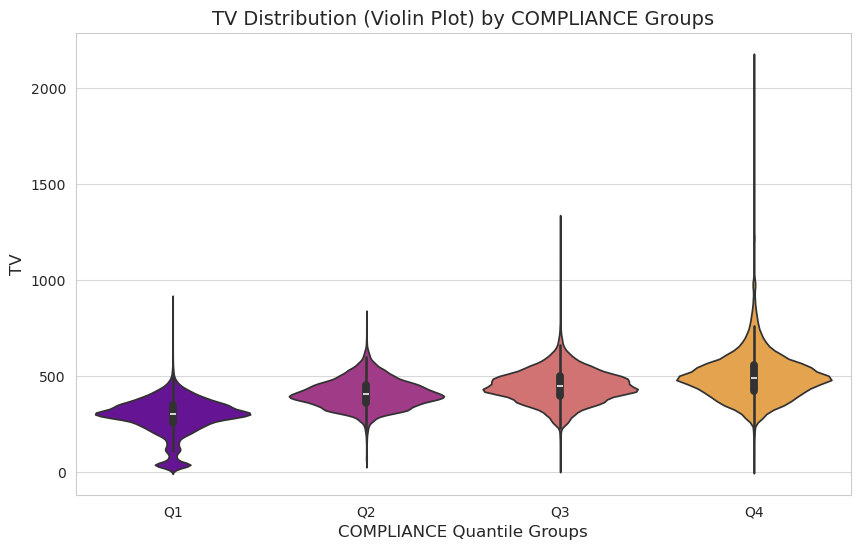


--- Grouped Analysis: 'TV' by Bins of 'FLOW_AIR' ---

Summary Statistics of 'TV' by 'FLOW_AIR' Bins:
                       count        mean         std   min    25%    50%  \
FLOW_AIR_Binned_Q4                                                         
Q1                   63015.0  324.710355   96.836362  12.0  276.0  314.0   
Q2                  108567.0  442.649553  121.613117  12.0  380.0  447.0   
Q3                   54869.0  438.258561   98.150930  27.0  378.0  427.0   
Q4                   24786.0  423.817316  125.219518  15.0  363.0  426.0   

                      75%     max  
FLOW_AIR_Binned_Q4                 
Q1                  367.0  1657.0  
Q2                  510.0  2150.0  
Q3                  492.0  1326.0  
Q4                  489.0  1258.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


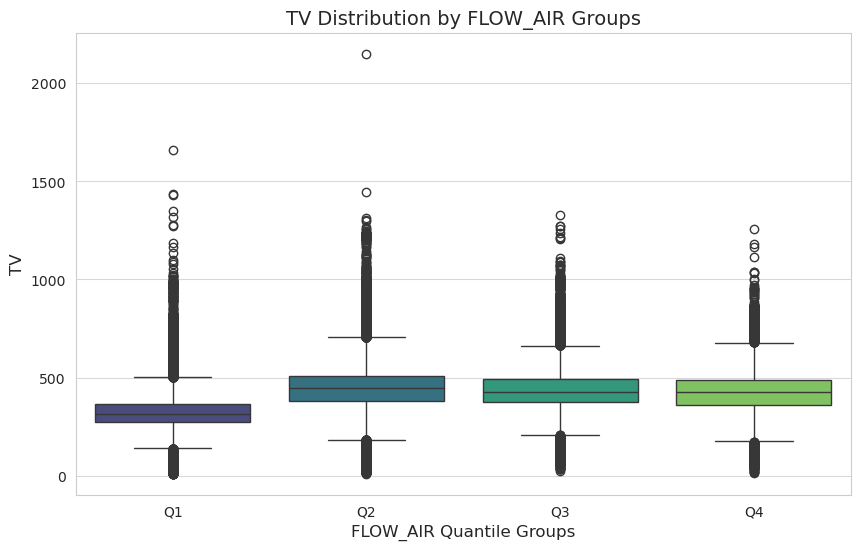

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


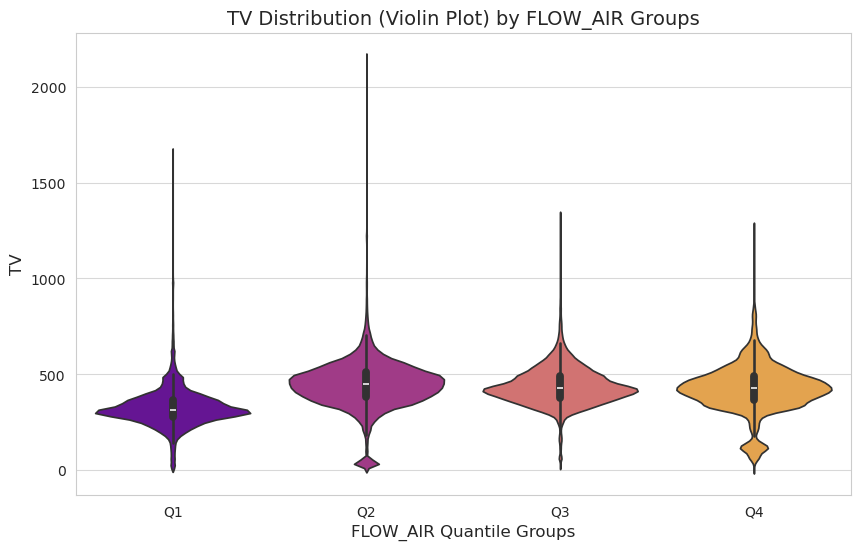


==================== END OF ANALYSIS FOR FEATURE: TV ====================



==================== DETAILED ANALYSIS FOR FEATURE: PIP_MBAR ====================

--- Analyzing Feature: 'PIP_MBAR' ---

Summary Statistics for 'PIP_MBAR':
count    251237.000000
mean         25.102115
std           4.882582
min           0.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          57.000000
Name: PIP_MBAR, dtype: float64


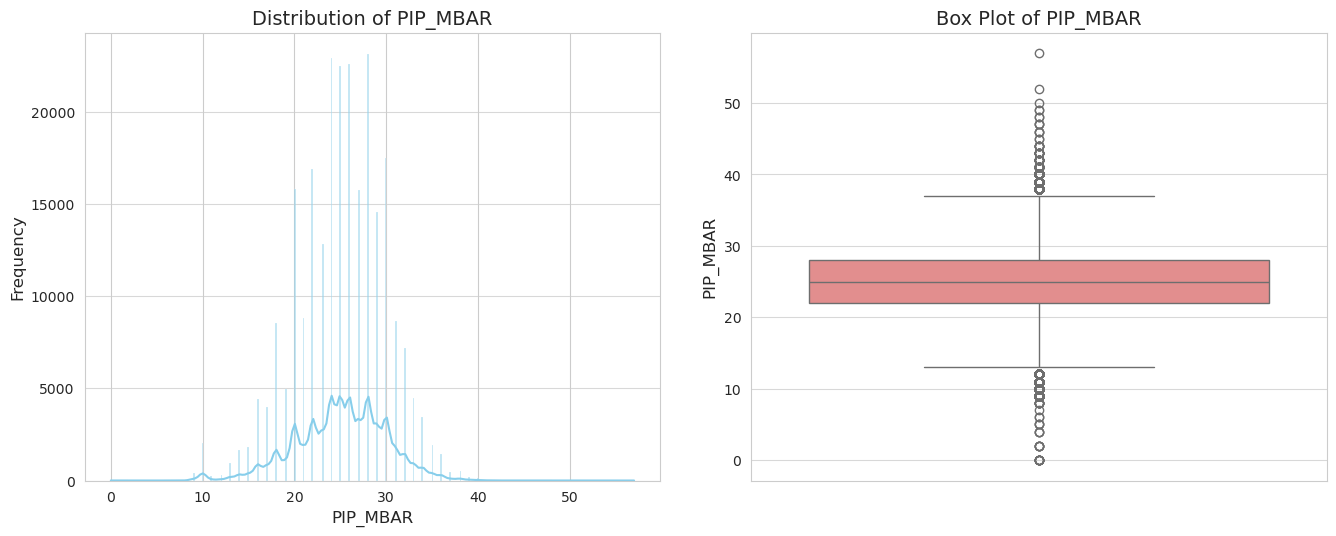


--- Scatter Plots for 'PIP_MBAR' vs. Top Correlated Features ---


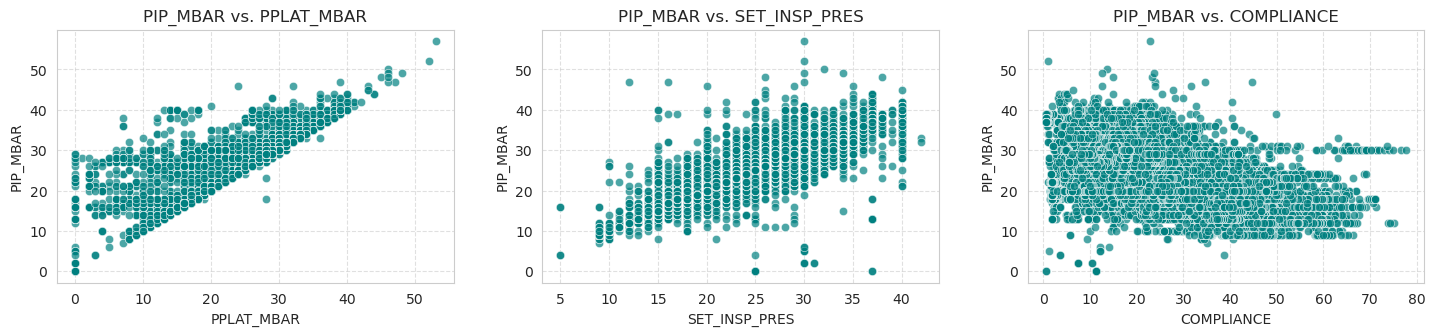


--- Exploring how 'PIP_MBAR' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'PIP_MBAR' by Bins of 'PPLAT_MBAR' ---

Summary Statistics of 'PIP_MBAR' by 'PPLAT_MBAR' Bins:
                        count       mean       std   min   25%   50%   75%  \
PPLAT_MBAR_Binned_Q4                                                         
Q1                    74694.0  19.356106  3.149183   0.0  18.0  20.0  22.0   
Q2                    66567.0  24.547839  1.037220  23.0  24.0  25.0  25.0   
Q3                    55883.0  27.453268  1.073885  18.0  27.0  28.0  28.0   
Q4                    54093.0  31.289594  2.132977  28.0  30.0  31.0  32.0   

                       max  
PPLAT_MBAR_Binned_Q4        
Q1                    41.0  
Q2                    46.0  
Q3                    41.0  
Q4                    57.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


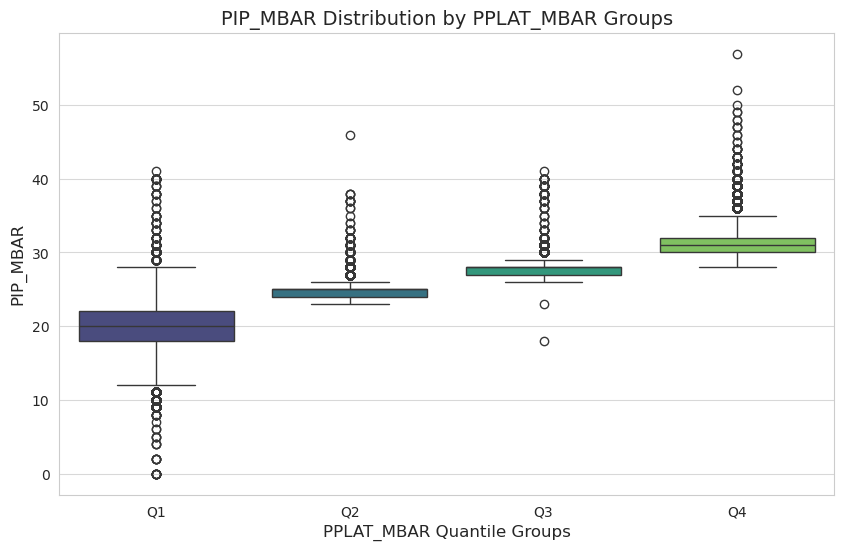

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


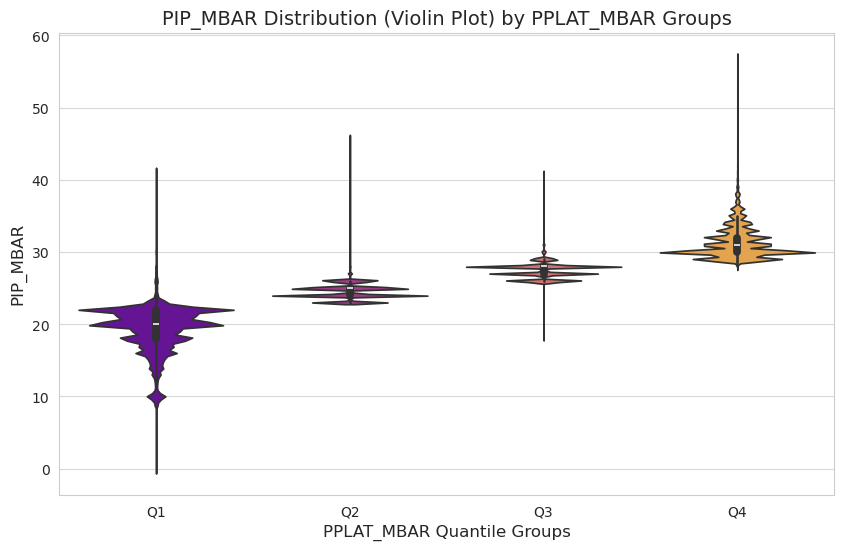


--- Grouped Analysis: 'PIP_MBAR' by Bins of 'SET_INSP_PRES' ---

Summary Statistics of 'PIP_MBAR' by 'SET_INSP_PRES' Bins:
                           count       mean       std   min   25%   50%   75%  \
SET_INSP_PRES_Binned_Q4                                                         
Q1                       72028.0  19.205212  3.020847   4.0  18.0  20.0  22.0   
Q2                       62693.0  24.487056  1.150143   0.0  24.0  24.0  25.0   
Q3                       66765.0  27.461529  1.599759  11.0  26.0  28.0  28.0   
Q4                       49751.0  31.248236  2.451148   0.0  30.0  31.0  33.0   

                          max  
SET_INSP_PRES_Binned_Q4        
Q1                       47.0  
Q2                       42.0  
Q3                       48.0  
Q4                       57.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


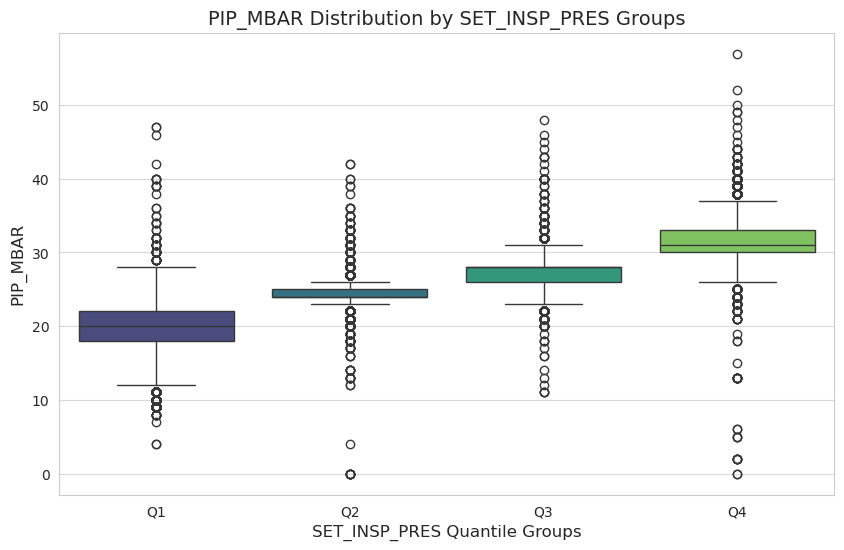

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


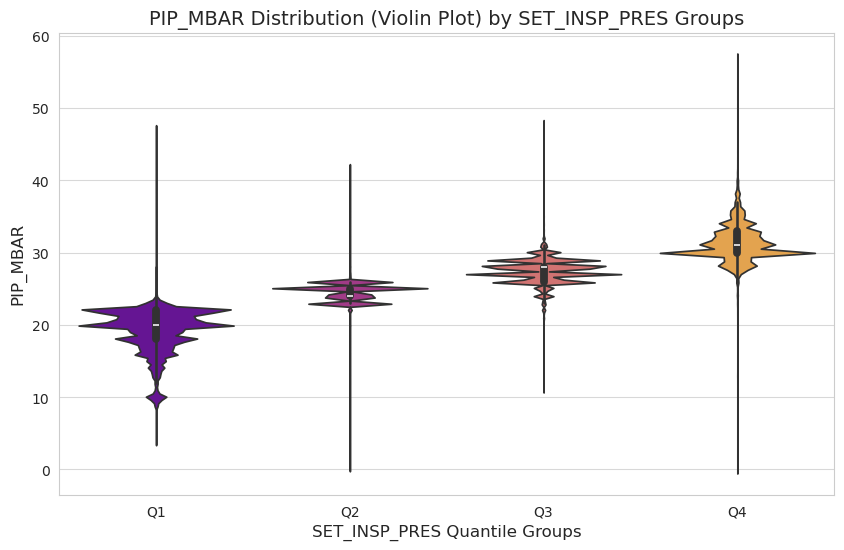


==================== END OF ANALYSIS FOR FEATURE: PIP_MBAR ====================



==================== DETAILED ANALYSIS FOR FEATURE: PEEP_MBAR ====================

--- Analyzing Feature: 'PEEP_MBAR' ---

Summary Statistics for 'PEEP_MBAR':
count    251237.000000
mean          4.393692
std           2.287213
min          -3.000000
25%           4.000000
50%           5.000000
75%           5.000000
max          32.000000
Name: PEEP_MBAR, dtype: float64


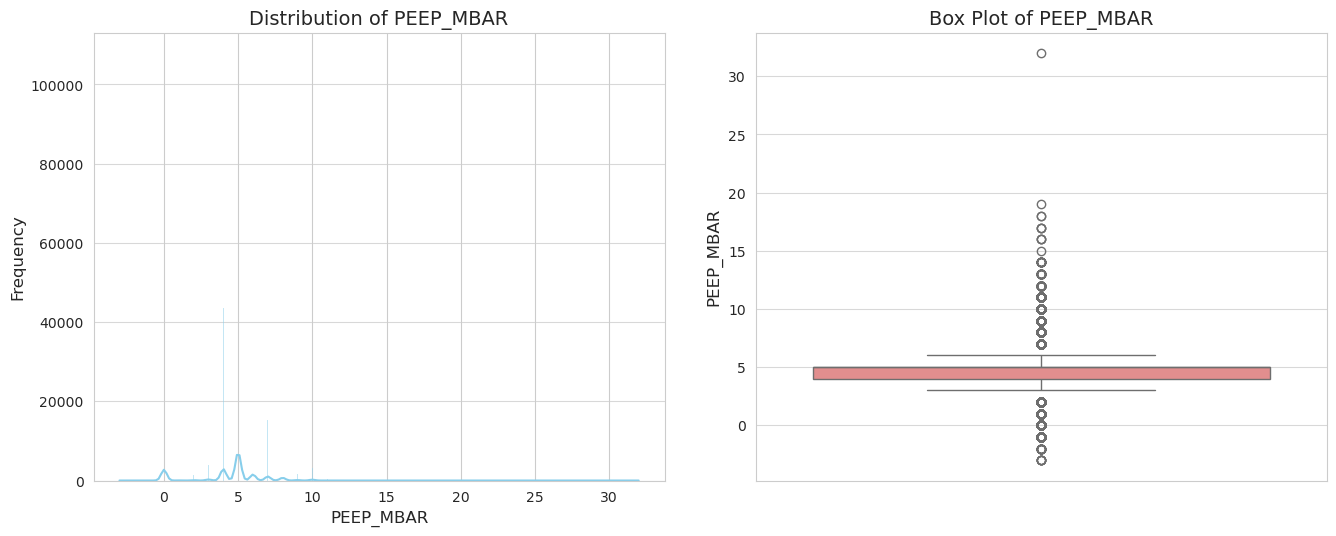


--- Scatter Plots for 'PEEP_MBAR' vs. Top Correlated Features ---


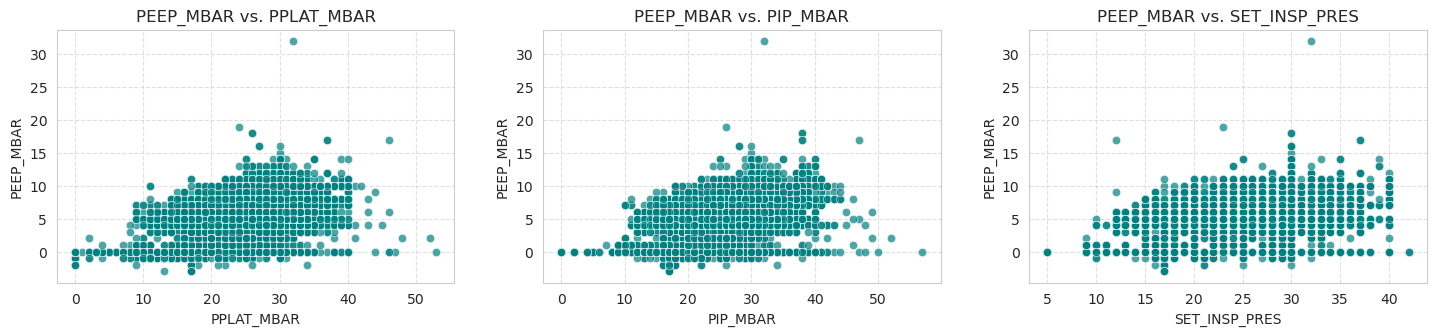


--- Exploring how 'PEEP_MBAR' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'PEEP_MBAR' by Bins of 'PPLAT_MBAR' ---

Summary Statistics of 'PEEP_MBAR' by 'PPLAT_MBAR' Bins:
                        count      mean       std  min  25%  50%  75%   max
PPLAT_MBAR_Binned_Q4                                                       
Q1                    74694.0  3.718384  2.454145 -3.0  0.0  5.0  5.0  11.0
Q2                    66567.0  4.435696  2.276168 -1.0  4.0  5.0  5.0  19.0
Q3                    55883.0  4.568921  2.090998 -2.0  4.0  5.0  5.0  18.0
Q4                    54093.0  5.093469  1.983662 -2.0  4.0  5.0  6.0  32.0


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


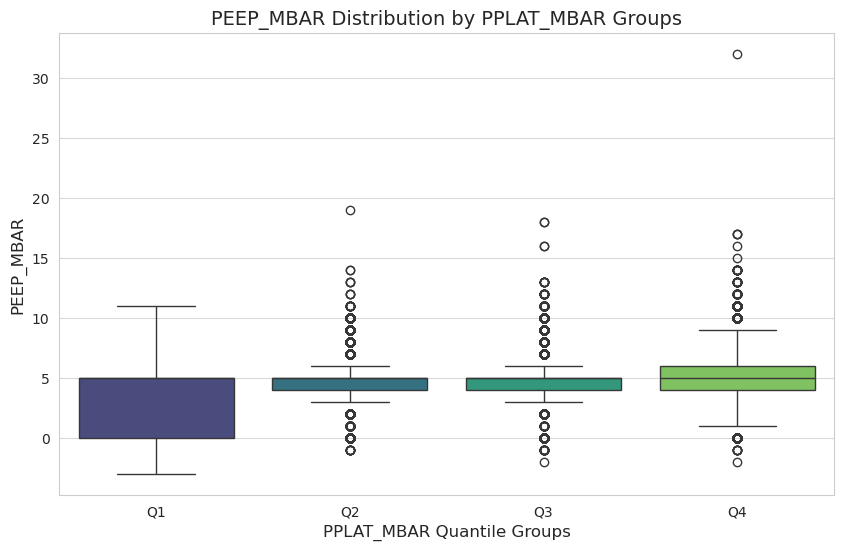

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


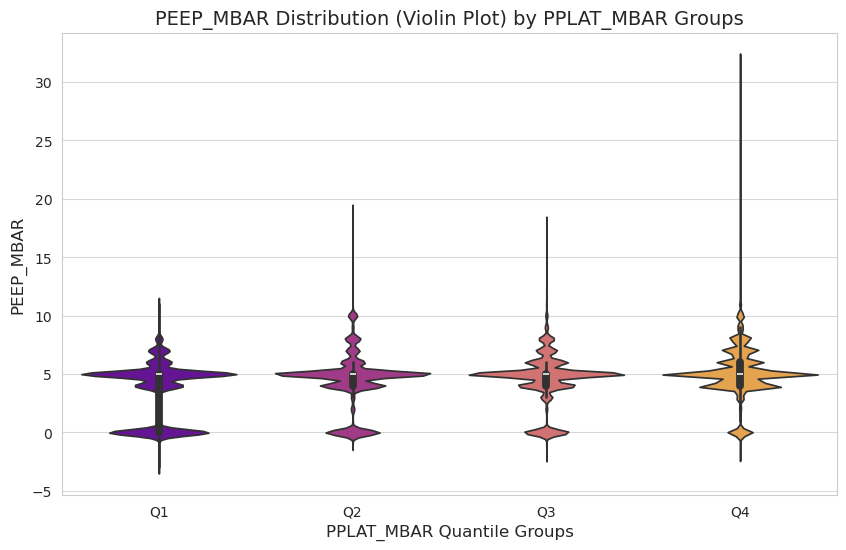


--- Grouped Analysis: 'PEEP_MBAR' by Bins of 'PIP_MBAR' ---

Summary Statistics of 'PEEP_MBAR' by 'PIP_MBAR' Bins:
                      count      mean       std  min  25%  50%  75%   max
PIP_MBAR_Binned_Q4                                                       
Q1                  70831.0  3.766119  2.436659 -3.0  0.0  5.0  5.0  11.0
Q2                  58227.0  4.363148  2.309355 -1.0  4.0  5.0  5.0  14.0
Q3                  61478.0  4.458408  2.083060 -2.0  4.0  5.0  5.0  19.0
Q4                  60701.0  5.089751  2.065090 -2.0  4.0  5.0  6.0  32.0


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


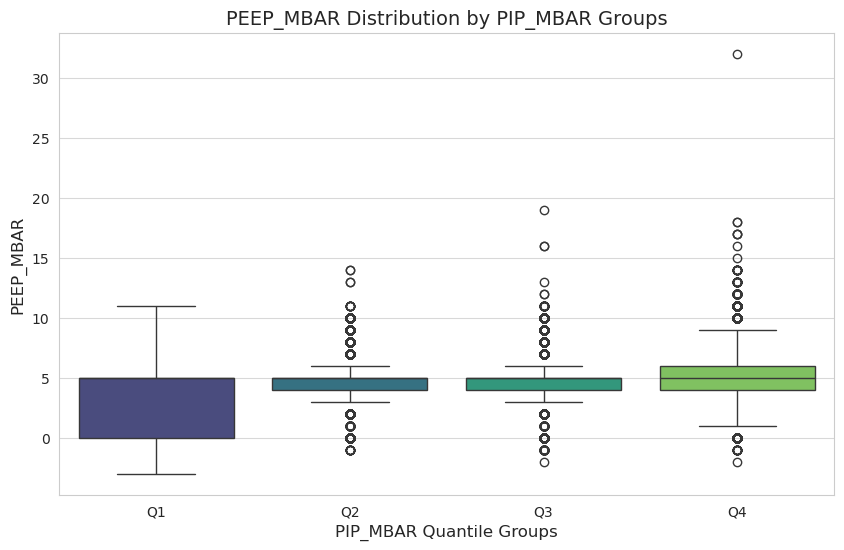

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


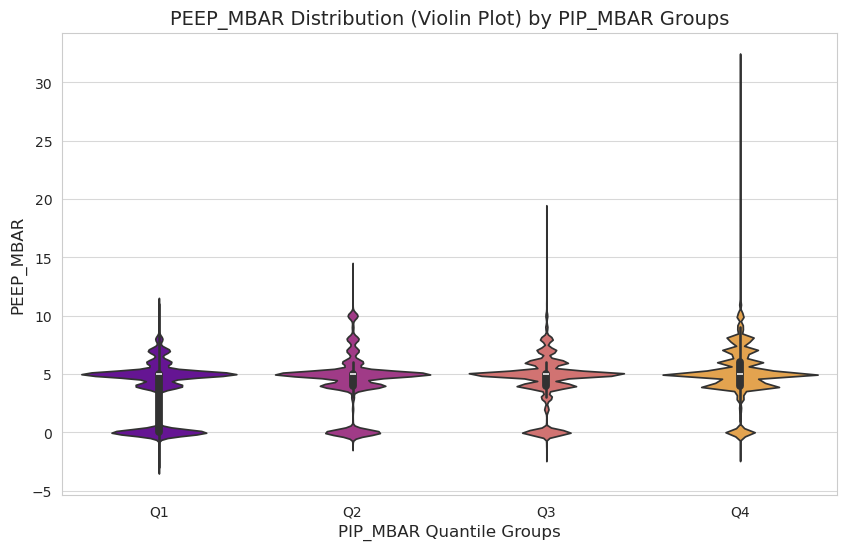


==================== END OF ANALYSIS FOR FEATURE: PEEP_MBAR ====================



==================== DETAILED ANALYSIS FOR FEATURE: PPLAT_MBAR ====================

--- Analyzing Feature: 'PPLAT_MBAR' ---

Summary Statistics for 'PPLAT_MBAR':
count    251237.000000
mean         24.726601
std           4.874340
min           0.000000
25%          22.000000
50%          25.000000
75%          28.000000
max          53.000000
Name: PPLAT_MBAR, dtype: float64


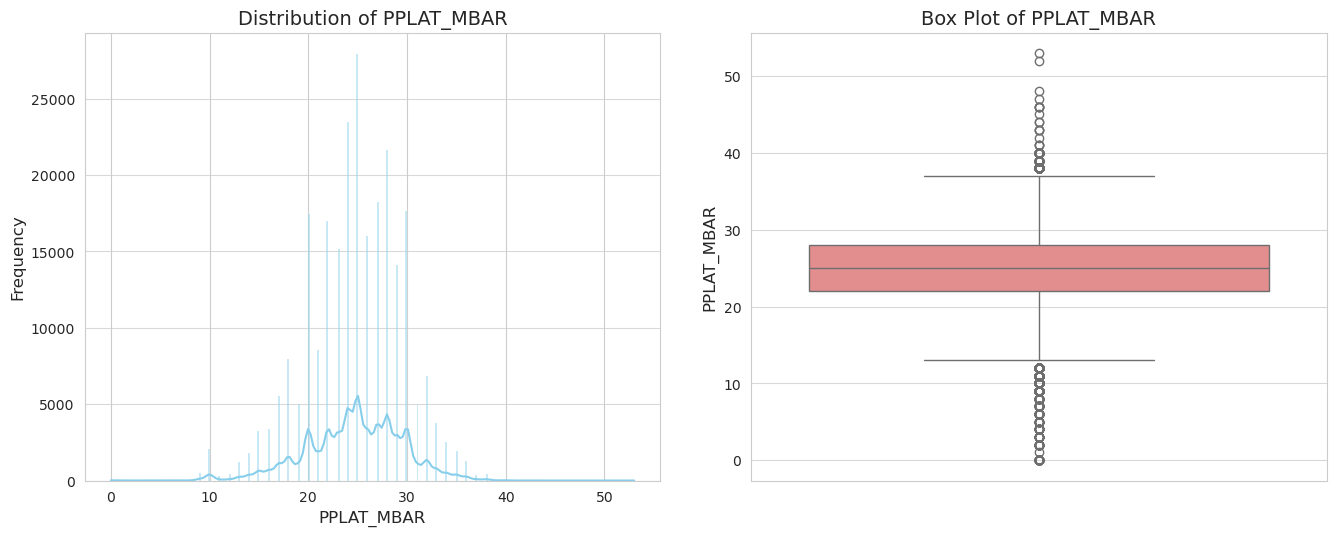


--- Scatter Plots for 'PPLAT_MBAR' vs. Top Correlated Features ---


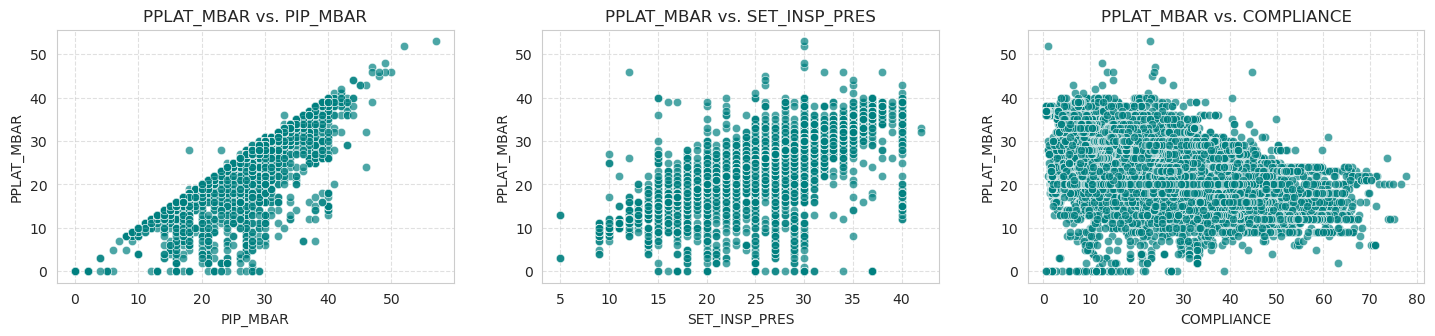


--- Exploring how 'PPLAT_MBAR' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'PPLAT_MBAR' by Bins of 'PIP_MBAR' ---

Summary Statistics of 'PPLAT_MBAR' by 'PIP_MBAR' Bins:
                      count       mean       std  min   25%   50%   75%   max
PIP_MBAR_Binned_Q4                                                           
Q1                  70831.0  18.831882  3.060379  0.0  17.0  20.0  21.0  28.0
Q2                  58227.0  23.917993  1.080736  0.0  23.0  24.0  25.0  28.0
Q3                  61478.0  26.530027  1.501695  0.0  26.0  27.0  28.0  29.0
Q4                  60701.0  30.554192  2.361278  0.0  29.0  30.0  32.0  53.0


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


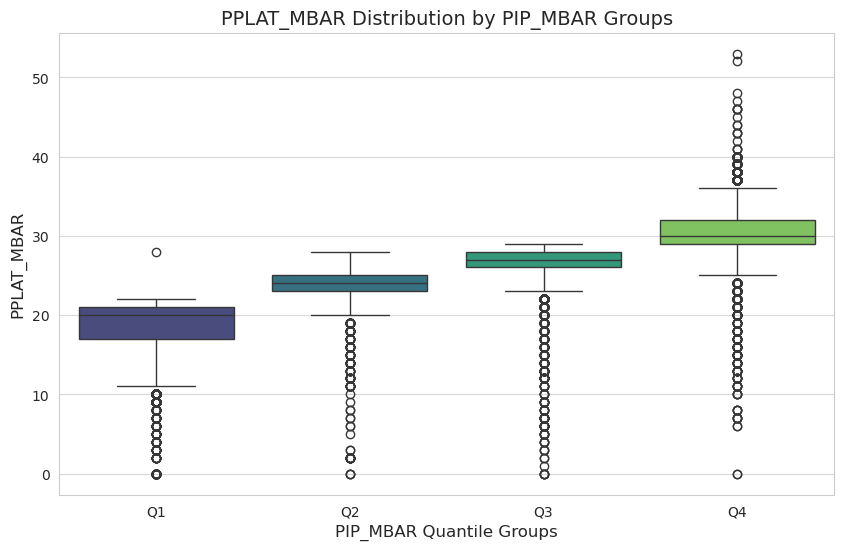

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


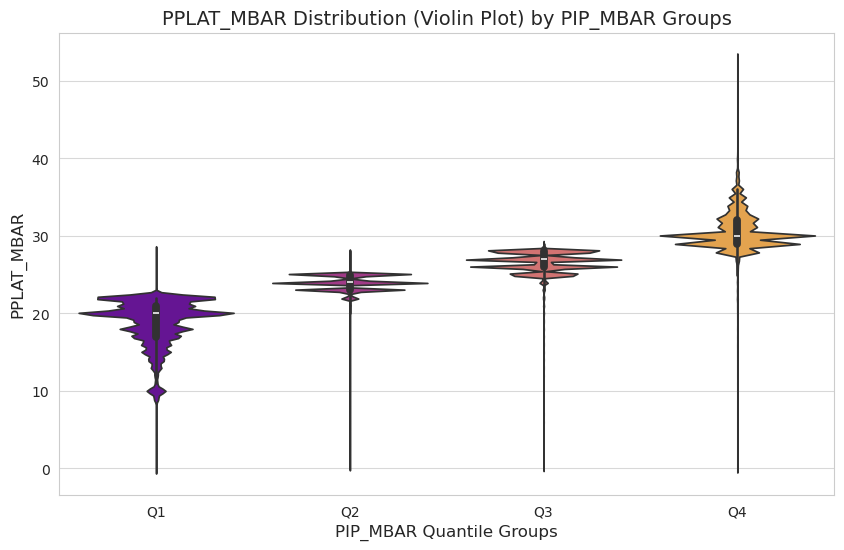


--- Grouped Analysis: 'PPLAT_MBAR' by Bins of 'SET_INSP_PRES' ---

Summary Statistics of 'PPLAT_MBAR' by 'SET_INSP_PRES' Bins:
                           count       mean       std  min   25%   50%   75%  \
SET_INSP_PRES_Binned_Q4                                                        
Q1                       72028.0  18.924307  3.058492  0.0  17.0  20.0  21.0   
Q2                       62693.0  24.098767  1.297599  0.0  23.0  24.0  25.0   
Q3                       66765.0  27.026017  1.735782  0.0  26.0  27.0  28.0   
Q4                       49751.0  30.832365  2.580514  0.0  30.0  30.0  32.0   

                          max  
SET_INSP_PRES_Binned_Q4        
Q1                       46.0  
Q2                       41.0  
Q3                       45.0  
Q4                       53.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


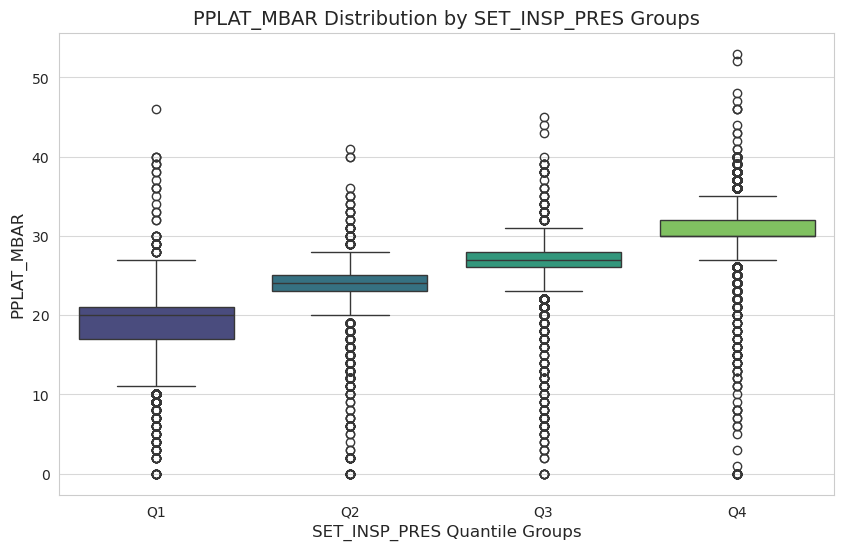

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


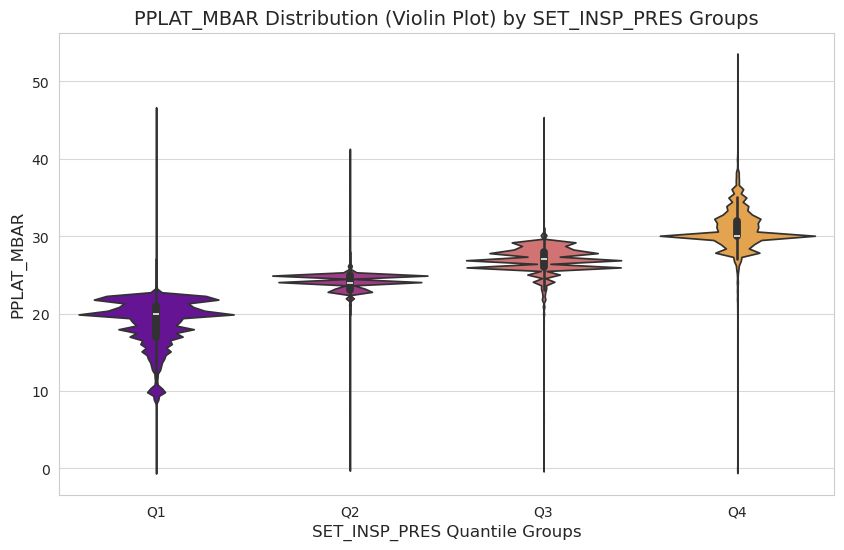


==================== END OF ANALYSIS FOR FEATURE: PPLAT_MBAR ====================



==================== DETAILED ANALYSIS FOR FEATURE: COMPLIANCE ====================

--- Analyzing Feature: 'COMPLIANCE' ---

Summary Statistics for 'COMPLIANCE':
count    251237.000000
mean         21.481518
std           8.247189
min           0.500000
25%          16.500000
50%          20.500000
75%          25.299999
max          77.800003
Name: COMPLIANCE, dtype: float64


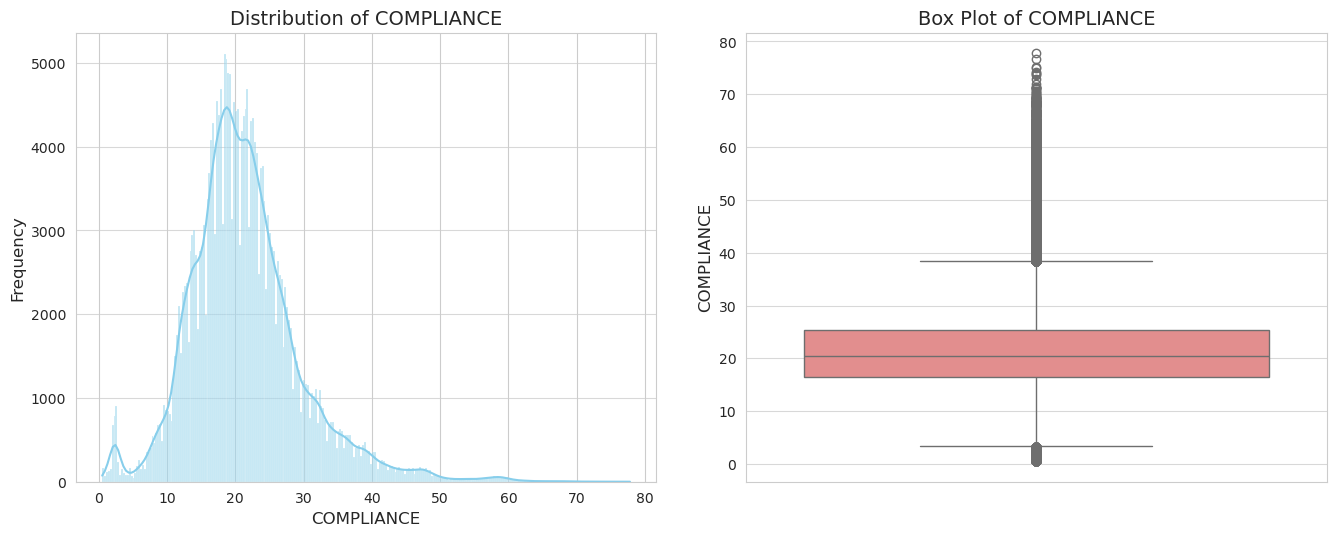


--- Scatter Plots for 'COMPLIANCE' vs. Top Correlated Features ---


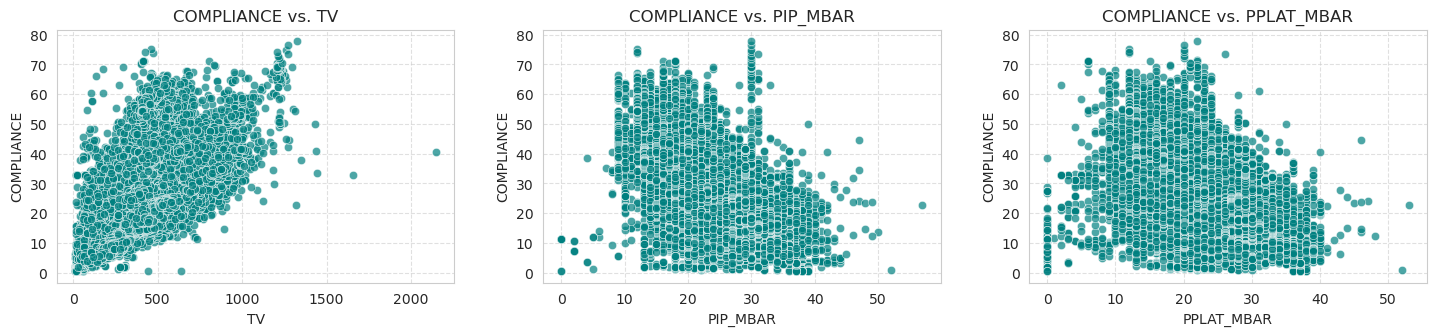


--- Exploring how 'COMPLIANCE' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'COMPLIANCE' by Bins of 'TV' ---

Summary Statistics of 'COMPLIANCE' by 'TV' Bins:
                count       mean       std  min   25%        50%        75%  \
TV_Binned_Q4                                                                  
Q1            63026.0  14.712182  6.672201  0.5  11.3  13.700000  17.600000   
Q2            62960.0  20.350910  5.724326  5.4  16.5  19.000000  23.200001   
Q3            62882.0  23.210819  6.485341  0.5  19.0  21.900000  25.600000   
Q4            62369.0  27.719959  7.999083  0.5  22.0  25.700001  31.799999   

                    max  
TV_Binned_Q4             
Q1            69.199997  
Q2            70.599998  
Q3            75.099998  
Q4            77.800003  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


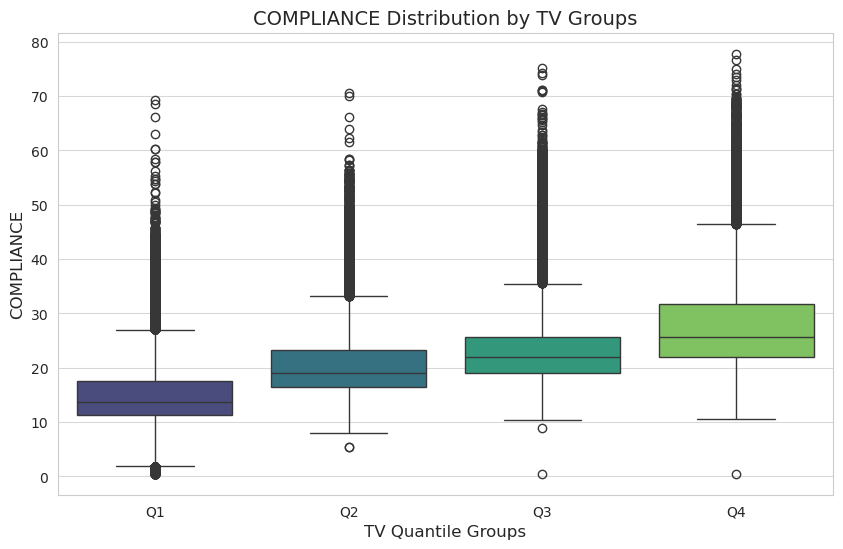

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


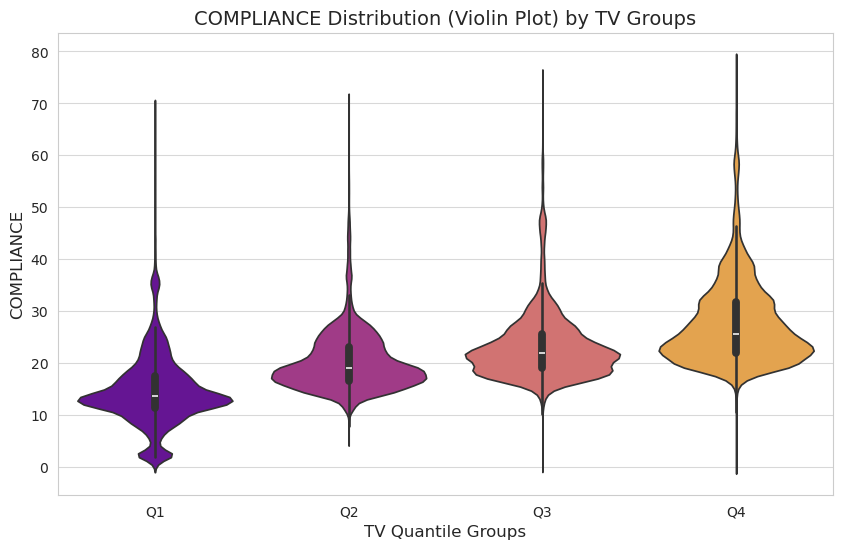


--- Grouped Analysis: 'COMPLIANCE' by Bins of 'PIP_MBAR' ---

Summary Statistics of 'COMPLIANCE' by 'PIP_MBAR' Bins:
                      count       mean       std  min        25%        50%  \
PIP_MBAR_Binned_Q4                                                            
Q1                  70831.0  27.027494  9.911462  0.5  22.200001  26.200001   
Q2                  58227.0  22.505913  6.777656  1.6  17.700001  21.900000   
Q3                  61478.0  19.271956  5.043849  1.1  16.299999  19.100000   
Q4                  60701.0  16.265211  5.291716  0.5  12.600000  16.500000   

                     75%        max  
PIP_MBAR_Binned_Q4                   
Q1                  31.6  75.099998  
Q2                  25.9  69.099998  
Q3                  22.1  63.099998  
Q4                  19.4  77.800003  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


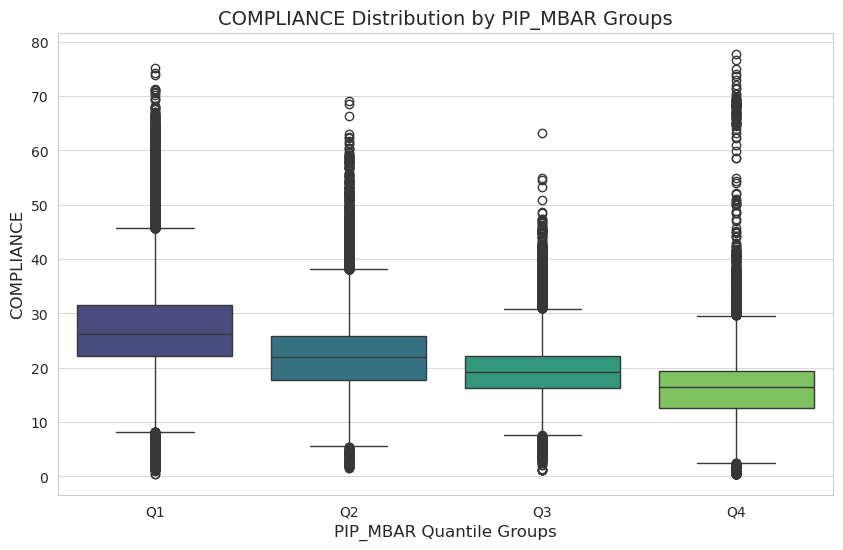

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


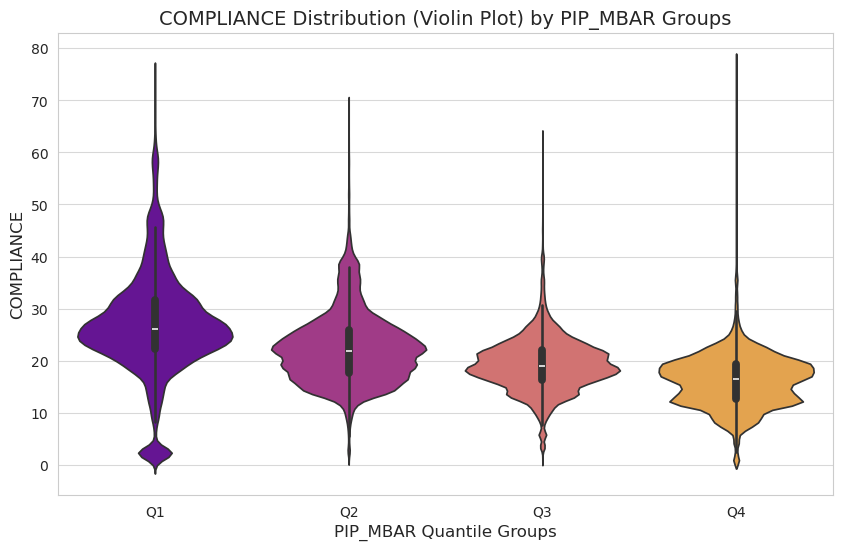


==================== END OF ANALYSIS FOR FEATURE: COMPLIANCE ====================



==================== DETAILED ANALYSIS FOR FEATURE: SET_INSP_TM ====================

--- Analyzing Feature: 'SET_INSP_TM' ---

Summary Statistics for 'SET_INSP_TM':
count    251237.000000
mean          1.312570
std           0.275234
min           0.600000
25%           1.100000
50%           1.300000
75%           1.500000
max           5.200000
Name: SET_INSP_TM, dtype: float64


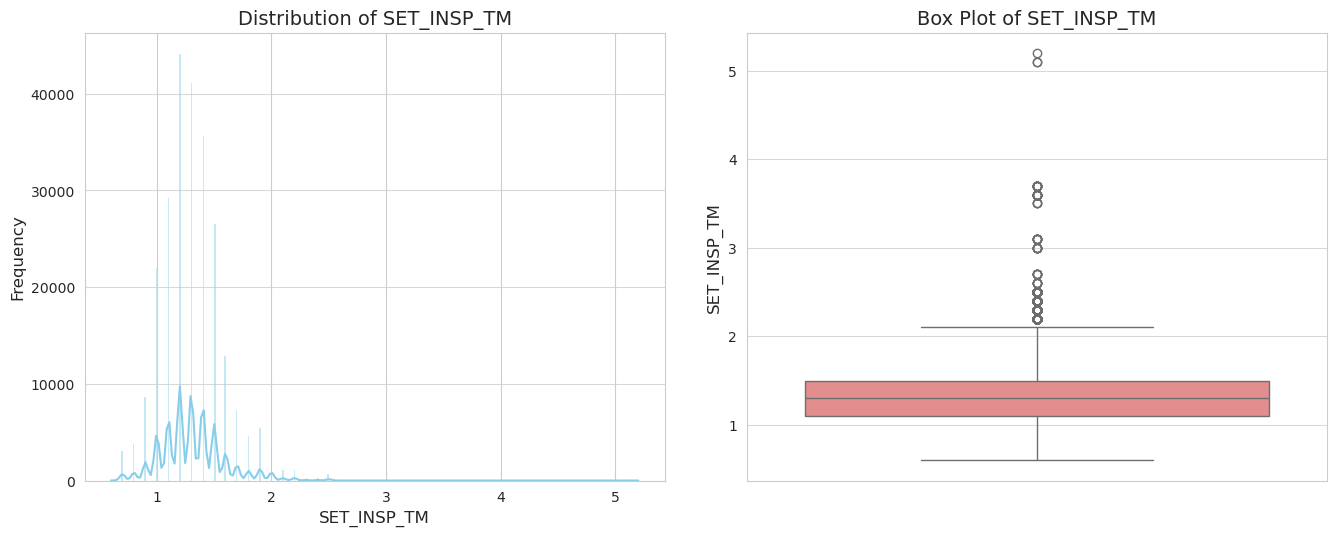


--- Scatter Plots for 'SET_INSP_TM' vs. Top Correlated Features ---


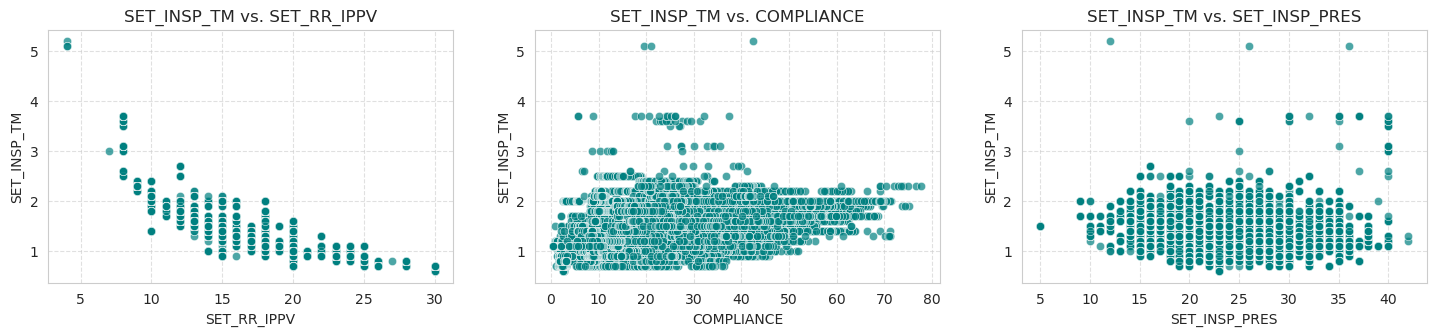


--- Exploring how 'SET_INSP_TM' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'SET_INSP_TM' by Bins of 'SET_RR_IPPV' ---

Summary Statistics of 'SET_INSP_TM' by 'SET_RR_IPPV' Bins:
                         count      mean       std  min  25%  50%  75%  max
SET_RR_IPPV_Binned_Q4                                                      
Q1                     95300.0  1.545674  0.231648  0.9  1.4  1.5  1.6  5.2
Q2                     51890.0  1.318063  0.150260  0.9  1.2  1.3  1.3  2.0
Q3                     58198.0  1.182730  0.106623  0.9  1.1  1.2  1.2  2.0
Q4                     45849.0  0.986645  0.151593  0.6  0.9  1.0  1.0  1.6


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


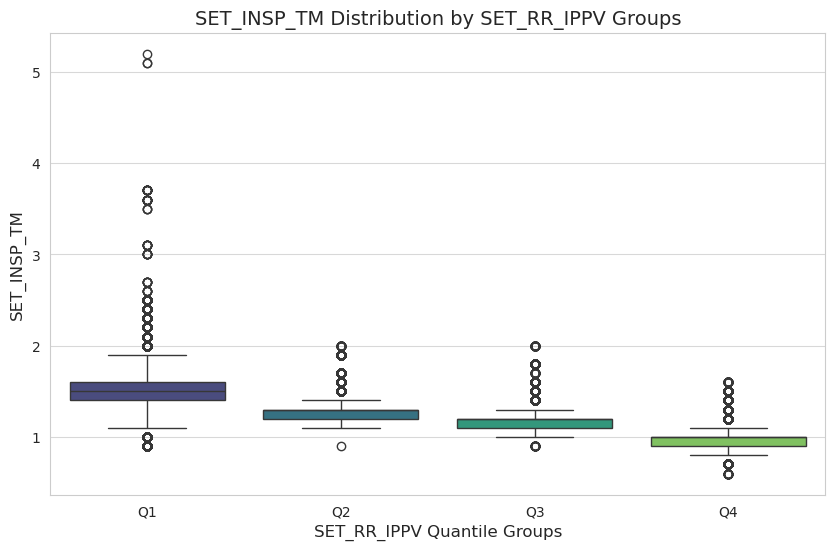

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


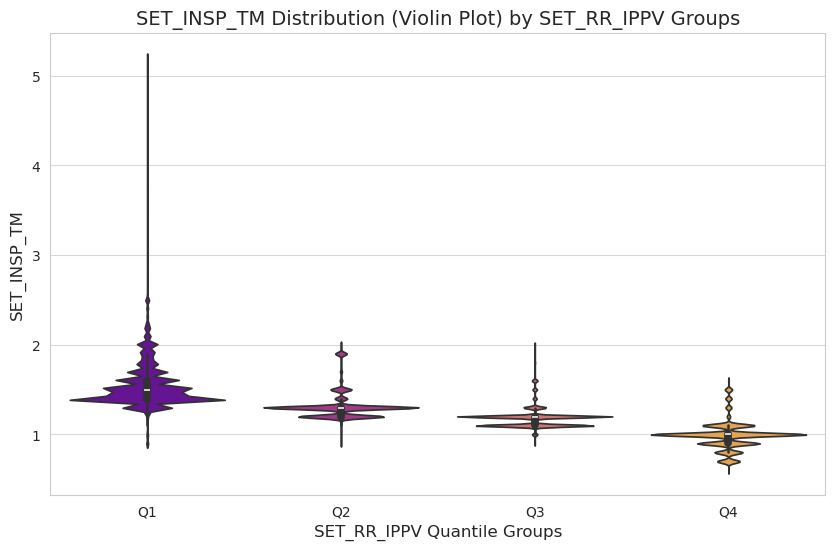


--- Grouped Analysis: 'SET_INSP_TM' by Bins of 'COMPLIANCE' ---

Summary Statistics of 'SET_INSP_TM' by 'COMPLIANCE' Bins:
                        count      mean       std  min  25%  50%  75%  max
COMPLIANCE_Binned_Q4                                                      
Q1                    64106.0  1.212993  0.274279  0.6  1.0  1.2  1.4  3.7
Q2                    61698.0  1.304911  0.225010  0.7  1.2  1.3  1.4  5.1
Q3                    62942.0  1.316550  0.255247  0.7  1.2  1.3  1.5  5.1
Q4                    62491.0  1.418275  0.300600  0.7  1.2  1.4  1.6  5.2


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


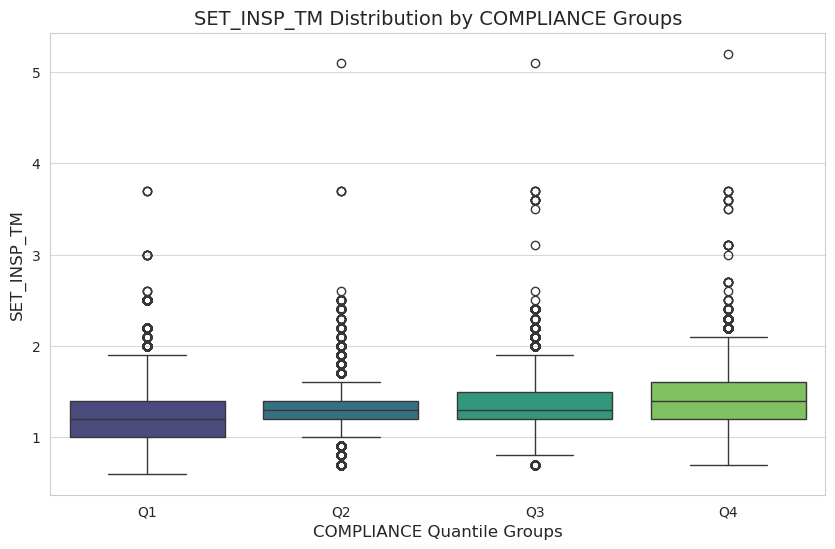

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


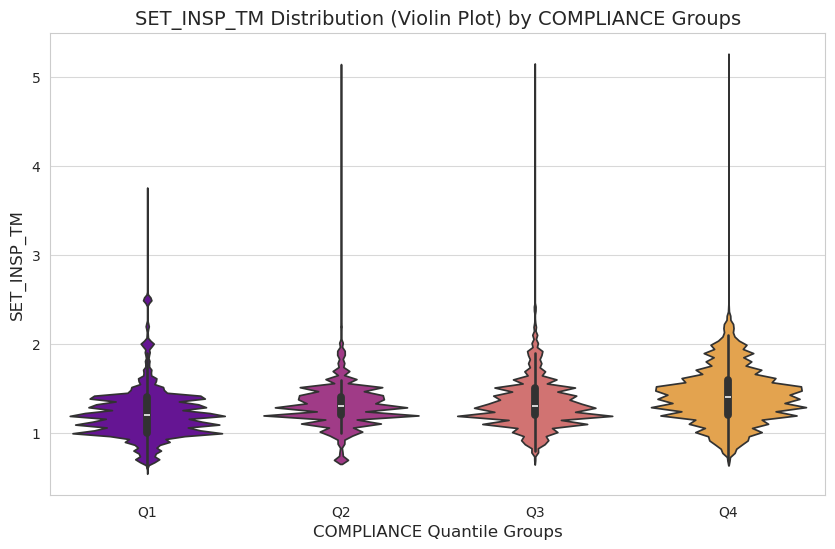


==================== END OF ANALYSIS FOR FEATURE: SET_INSP_TM ====================



==================== DETAILED ANALYSIS FOR FEATURE: FLOW_AIR ====================

--- Analyzing Feature: 'FLOW_AIR' ---

Summary Statistics for 'FLOW_AIR':
count    251237.000000
mean       1113.024734
std         578.521862
min           0.000000
25%         886.000000
50%        1266.000000
75%        1519.000000
max        9999.000000
Name: FLOW_AIR, dtype: float64


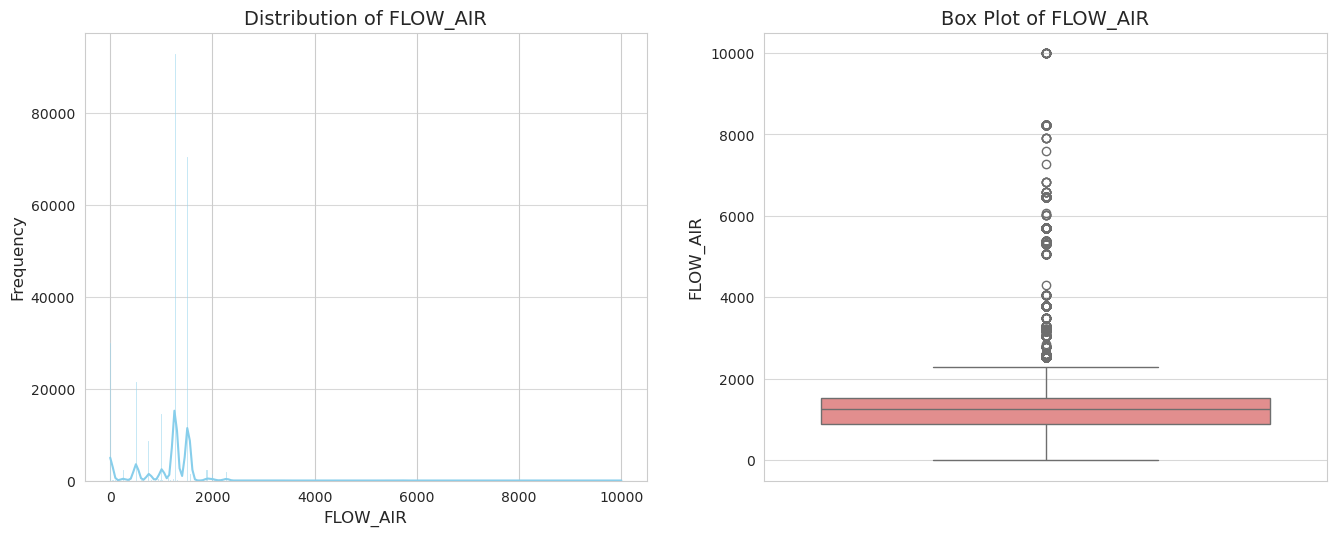


--- Scatter Plots for 'FLOW_AIR' vs. Top Correlated Features ---


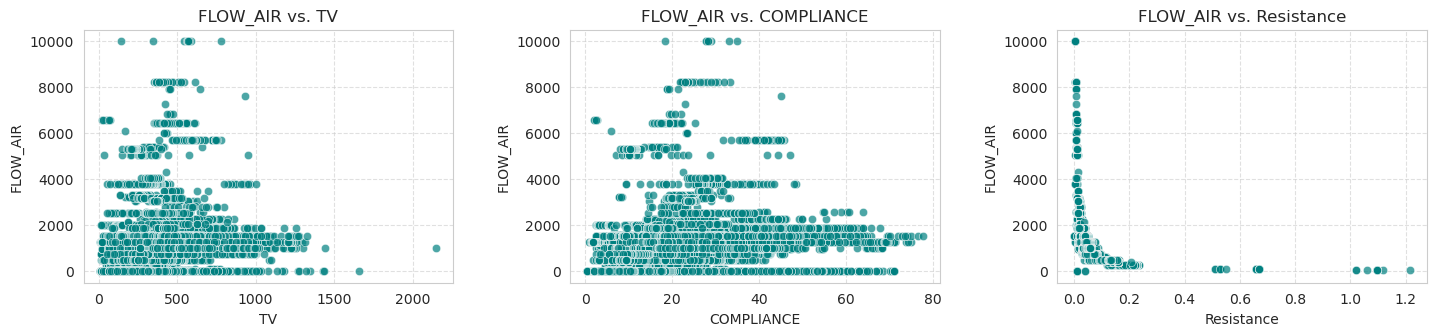


--- Exploring how 'FLOW_AIR' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'FLOW_AIR' by Bins of 'TV' ---

Summary Statistics of 'FLOW_AIR' by 'TV' Bins:
                count         mean         std  min     25%     50%     75%  \
TV_Binned_Q4                                                                  
Q1            63026.0   697.513851  650.612934  0.0     0.0   507.0  1266.0   
Q2            62960.0  1137.119060  549.186075  0.0   760.0  1266.0  1519.0   
Q3            62882.0  1315.940778  440.464875  0.0  1266.0  1266.0  1519.0   
Q4            62369.0  1304.004922  409.080070  0.0  1266.0  1266.0  1519.0   

                 max  
TV_Binned_Q4          
Q1            9999.0  
Q2            9999.0  
Q3            8228.0  
Q4            9999.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


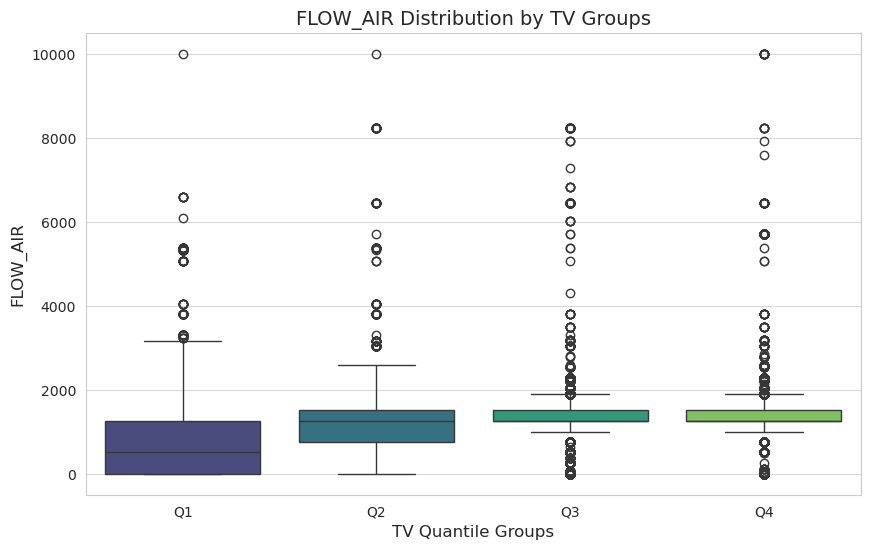

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


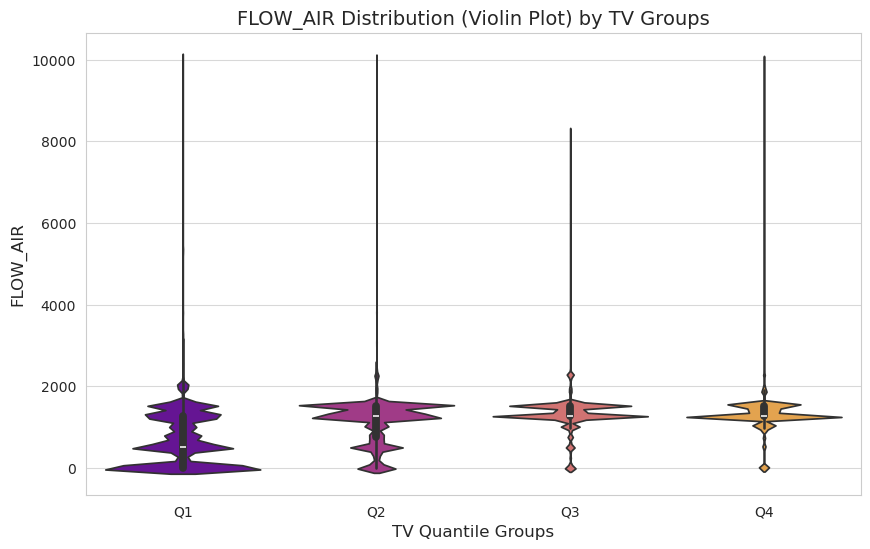


--- Grouped Analysis: 'FLOW_AIR' by Bins of 'COMPLIANCE' ---

Summary Statistics of 'FLOW_AIR' by 'COMPLIANCE' Bins:
                        count         mean         std  min     25%     50%  \
COMPLIANCE_Binned_Q4                                                          
Q1                    64106.0   773.468225  662.206339  0.0     0.0   759.0   
Q2                    61698.0  1197.881666  512.880922  0.0  1265.0  1266.0   
Q3                    62942.0  1233.523831  488.057112  0.0  1265.0  1266.0   
Q4                    62491.0  1256.207790  485.375948  0.0  1265.0  1266.0   

                         75%     max  
COMPLIANCE_Binned_Q4                  
Q1                    1266.0  6582.0  
Q2                    1519.0  9999.0  
Q3                    1519.0  8228.0  
Q4                    1519.0  9999.0  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


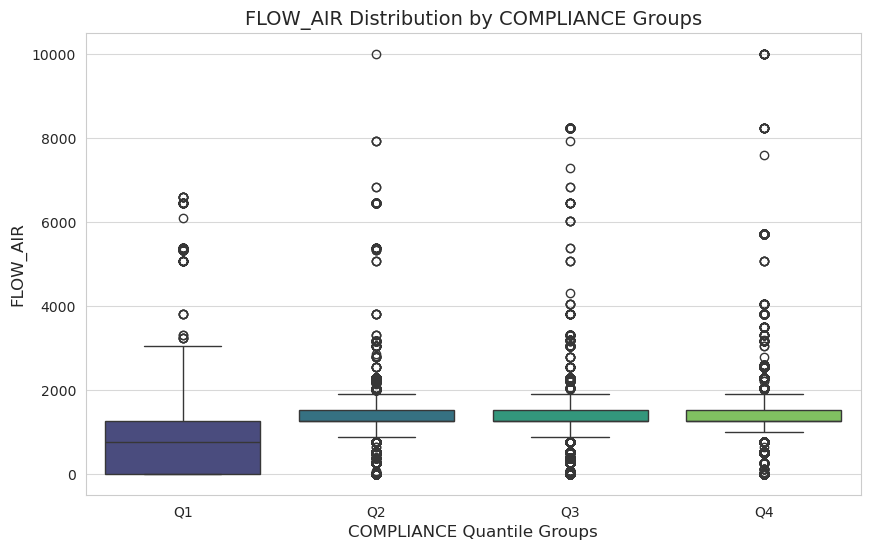

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


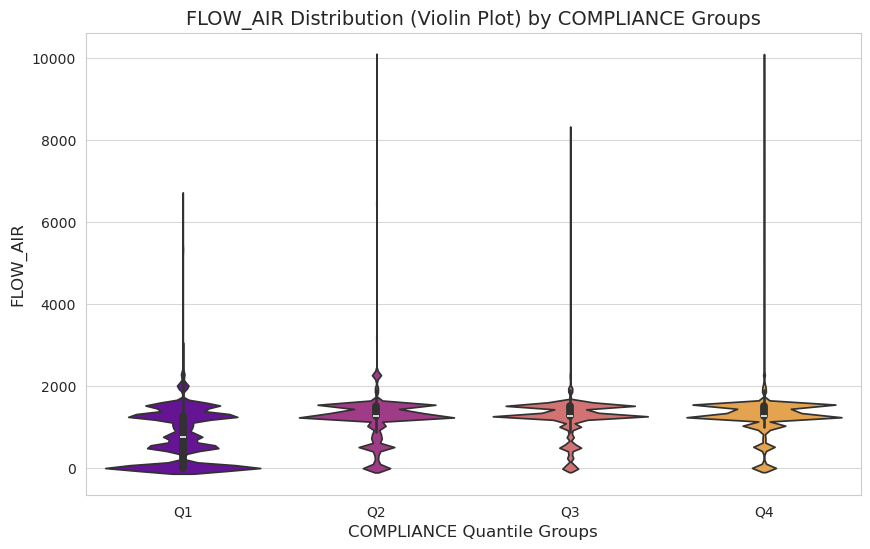


==================== END OF ANALYSIS FOR FEATURE: FLOW_AIR ====================



==================== DETAILED ANALYSIS FOR FEATURE: Resistance ====================

--- Analyzing Feature: 'Resistance' ---

Summary Statistics for 'Resistance':
count    251237.000000
mean          0.041213
std           0.027758
min           0.000000
25%           0.028963
50%           0.036232
75%           0.047393
max           1.215686
Name: Resistance, dtype: float64


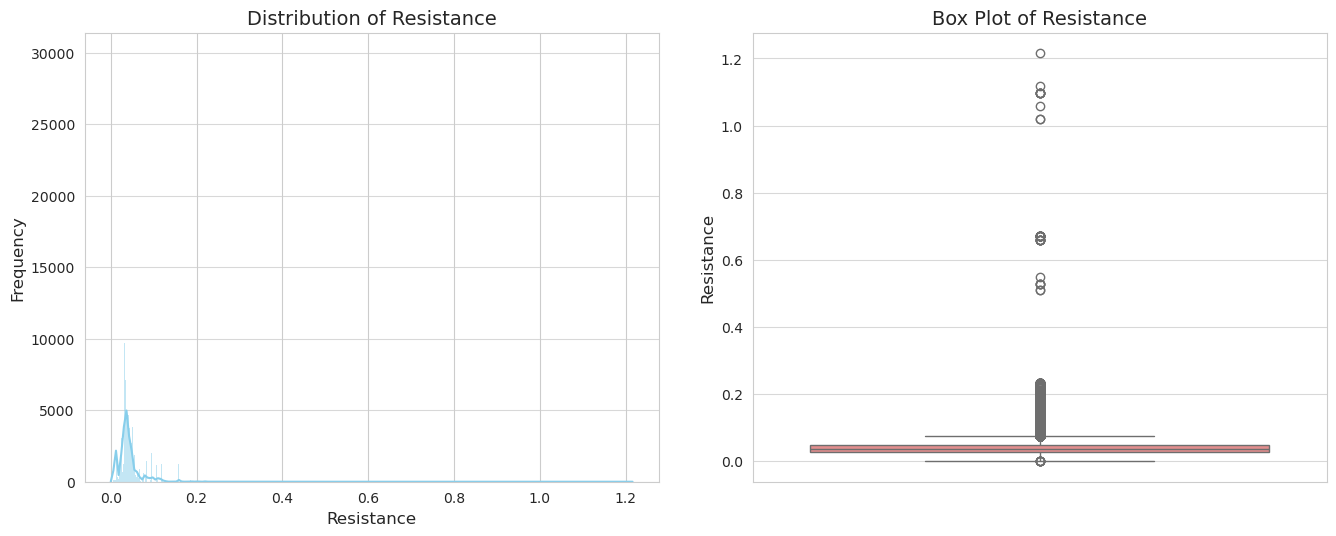


--- Scatter Plots for 'Resistance' vs. Top Correlated Features ---


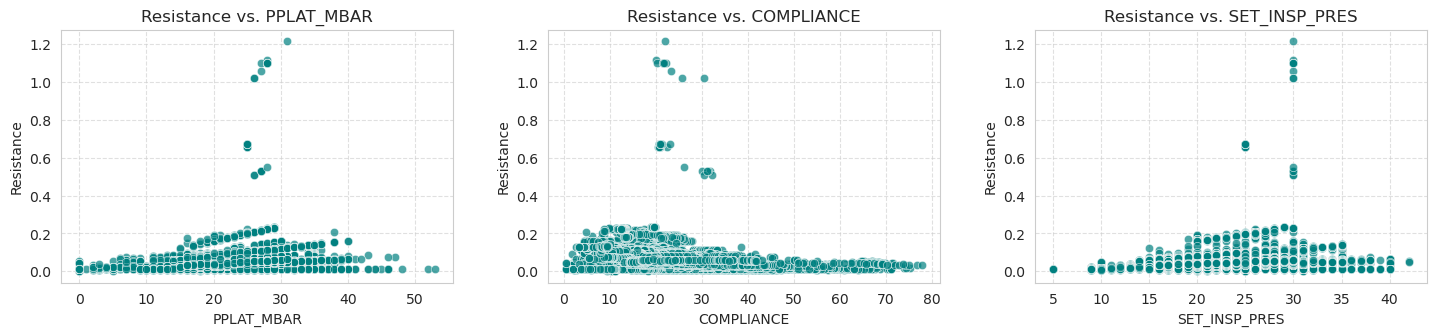


--- Exploring how 'Resistance' is influenced by other features (Grouped Analysis) ---

--- Grouped Analysis: 'Resistance' by Bins of 'PPLAT_MBAR' ---

Summary Statistics of 'Resistance' by 'PPLAT_MBAR' Bins:
                        count      mean       std       min       25%  \
PPLAT_MBAR_Binned_Q4                                                    
Q1                    74694.0  0.035107  0.025218  0.000000  0.023697   
Q2                    66567.0  0.042365  0.027515  0.005001  0.032258   
Q3                    55883.0  0.043898  0.029467  0.006698  0.035526   
Q4                    54093.0  0.045454  0.028166  0.008486  0.033702   

                           50%       75%       max  
PPLAT_MBAR_Binned_Q4                                
Q1                    0.028966  0.034755  0.189723  
Q2                    0.037125  0.040316  0.671053  
Q3                    0.041074  0.044234  1.117647  
Q4                    0.047431  0.052923  1.215686  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


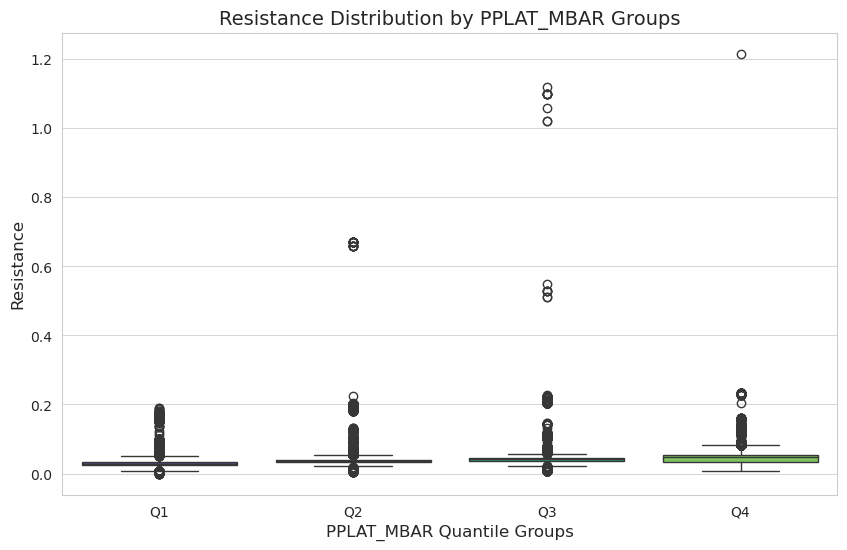

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


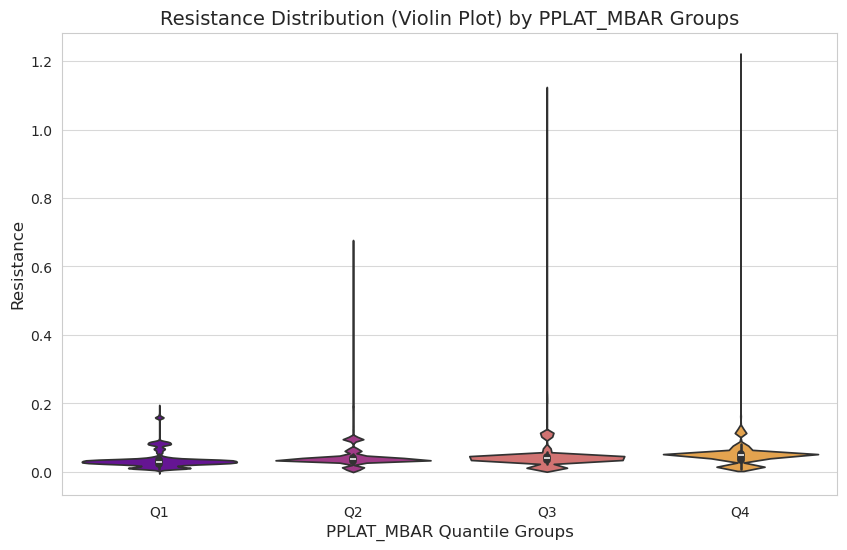


--- Grouped Analysis: 'Resistance' by Bins of 'COMPLIANCE' ---

Summary Statistics of 'Resistance' by 'COMPLIANCE' Bins:
                        count      mean       std       min       25%  \
COMPLIANCE_Binned_Q4                                                    
Q1                    64106.0  0.045190  0.035820  0.000000  0.010000   
Q2                    61698.0  0.045378  0.024817  0.003800  0.034256   
Q3                    62942.0  0.041575  0.028391  0.004861  0.031600   
Q4                    62491.0  0.032657  0.015967  0.003949  0.025276   

                           50%       75%       max  
COMPLIANCE_Binned_Q4                                
Q1                    0.037154  0.060032  0.229249  
Q2                    0.041074  0.048973  1.117647  
Q3                    0.037125  0.044234  1.215686  
Q4                    0.031600  0.037125  1.019608  


/tmp/ipykernel_395563/3059539139.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(filtered_df.groupby(grouping_col_binned_name)[primary_feature].describe())
/tmp/ipykernel_395563/3059539139.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='viridis')


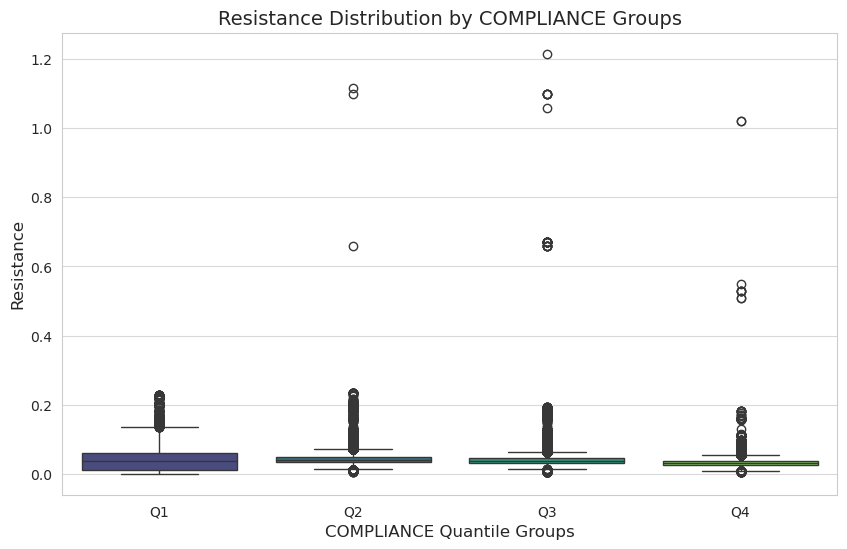

/tmp/ipykernel_395563/3059539139.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(x=grouping_col_binned_name, y=primary_feature, data=filtered_df, palette='plasma')


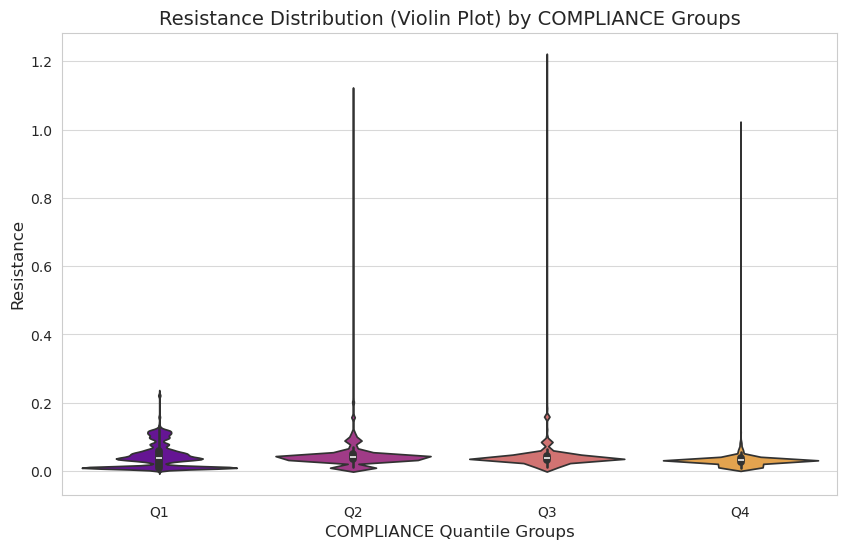


==================== END OF ANALYSIS FOR FEATURE: Resistance ====================



--- All EDA Complete ---


In [ ]:
EDA(dataset)